## Preproccessing and Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
import pickle
# import dcor 
# from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [36]:
tf.random.set_seed(13)
def mean_absolute_percentage_error(y_true, y_pred): 
  for i in range(len(y_true)):
    if y_true[i] == 0:
      print('MAPE * Founded')
      y_true[i] = np.mean(y_true)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('DowDataset.csv', sep=',', date_parser=True)
dataset1 = data.iloc[:343].copy()
dataset2 = data.iloc[396:754].copy()
dataset_test = data.iloc[761:].copy()
full_dataset = pd.concat([dataset1, dataset2, dataset_test], axis=0 , ignore_index=True)
full_dataset = full_dataset.drop(['DATE', 'Flow_to_EQ'], axis=1)

In [96]:
class approach1:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['trend'] = self.df[self.goal].rolling(7).mean().fillna(method='bfill')
    self.df['residual'] = self.df[self.goal] - self.df['trend']
    self.df['target'] = self.df['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [26, 30]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 1
      self.model_neurons = 32
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_layers = 1
      self.model_neurons = 26

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std

    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 6, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach1.h5')

  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100    
    for optimizer in OPTIMIZER:
      for num_layer in NUM_LAYER:
        if num_layer == 1:
          for neurons in NUM_UNITS:
            self.model = tf.keras.Sequential()
            self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
            self.model.add(Dense(1))
            self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
            history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
            # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history_Ann.history['val_loss']))
            self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
            print(self.tune_results[f'{n}'])
            if min(history_Ann.history['val_loss']) < min_score:
              min_score = min(history_Ann.history['val_loss'])
              min_score_pos = n
            n+=1
        if num_layer == 2:
          for neurons in NUM_UNITS:
            for neurons2 in NUM_UNITS:
              self.model = tf.keras.Sequential()
              self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
              self.model.add(Dense(neurons2, activation='relu'))
              self.model.add(Dense(1))
              self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
              history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)   
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history_Ann.history['val_loss'])) 
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history_Ann.history['val_loss']) < min_score:
                min_score = min(history_Ann.history['val_loss'])
                min_score_pos = n
              n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}']
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    self.df_test['trend'] = self.df_test[self.goal].rolling(7).mean().fillna(method='ffill')
    self.df_test = self.df_test.iloc[-self.df_test.shape[0]+7:]
    self.df_test['residual'] = self.df_test[self.goal] - self.df_test['trend']
    self.df_test['target'] = self.df_test['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON', 'residual']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.prediction = self.prediction*self.y_std + self.y_mean
    self.full_prediction = self.df_test['trend'].reset_index(drop=True) + self.prediction['Prediction']

    print('*** ANN estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()


In [97]:
class approach2:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_layers = 2
      self.model_neurons = [32, 4]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [2, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [18, 26]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def series_to_supervised(self, n_in=5, n_out=1, dropnan=True):
    self.n_in = n_in
    self.n_out = n_out

    n_vars = 1 if type(self.X_train) is list else self.X_train.shape[1]
    df = pd.DataFrame(self.X_train)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
      else:
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    self.supervised = agg
    self.supervised_train = self.supervised.values.reshape((self.supervised.shape[0], 1, self.supervised.shape[1]))
    self.Y_train = self.Y_train.iloc[n_in:]

  def training(self, neurons = [10, 14], max_epochs = 50):
    #print(neurons)
    self.model = tf.keras.Sequential()
    self.model.add(LSTM(self.model_neurons[0], activation='linear', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
    self.model.add(Dropout(0.1))
    if self.model_layers == 2:
      self.model.add(BatchNormalization())
      self.model.add(LSTM(self.model_neurons[1], activation='linear'))
    self.model.add(Dense(1))
    self.model.compile(loss='mse', optimizer=self.model_optimizer, metrics=['mape'])  
    history = self.model.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach2.h5')
  
  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100    
    for optimizer in OPTIMIZER:
      for num_layer in NUM_LAYER:
        if num_layer == 1:
          for neurons in NUM_UNITS:
            self.models = tf.keras.Sequential()
            self.models.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
            self.models.add(Dropout(0.1))
            self.models.add(Dense(1))
            self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
            history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
            # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history.history['val_loss']))
            self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
            print(self.tune_results[f'{n}'])
            if min(history.history['val_loss']) < min_score:
              min_score = min(history.history['val_loss'])
              min_score_pos = n
            n+=1
        if num_layer == 2:
          for neurons in NUM_UNITS:
            for neurons2 in NUM_UNITS:
              self.models = tf.keras.Sequential()
              self.models.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
              self.models.add(Dropout(0.1))
              self.models.add(BatchNormalization())
              self.models.add(LSTM(neurons2, activation='relu', return_sequences=True))
              self.models.add(Dense(1))
              self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
              history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1) 
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history.history['val_loss'])) 
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history.history['val_loss']) < min_score:
                min_score = min(history.history['val_loss'])
                min_score_pos = n
              n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}'] 

  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    def series_to_supervised_test(X_test, n_in=self.n_in, n_out=self.n_out, dropnan=True):
      n_vars = 1 if type(X_test) is list else X_test.shape[1]
      df = pd.DataFrame(X_test)
      cols, names = list(), list()
      # input sequence (t-n, ... t-1)
      for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
      # forecast sequence (t, t+1, ... t+n)
      for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
          names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
          names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
      # put it all together
      agg = pd.concat(cols, axis=1)
      agg.columns = names
      # drop rows with NaN values
      if dropnan:
        agg.dropna(inplace=True)
      supervised = agg
      supervised_test = supervised.values.reshape((supervised.shape[0], 1, supervised.shape[1]))
      return supervised_test
    # self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')

    # self.Xt = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill')
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill').iloc[self.n_in:]
    self.supervised_test = series_to_supervised_test(self.X_test)
    
    self.prediction = pd.DataFrame(self.model.predict(self.supervised_test).reshape(-1,1), columns=['Prediction'])
    self.full_prediction = self.prediction*self.y_std + self.y_mean
    
    print('*** LSTM estimation ***')
    # print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    # print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [98]:
class approach3:
  def __init__(self, df, goal):    
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON']].fillna(method='bfill')
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    
    # self.X = self.df[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='bfill')
    self.Y = self.df['target'].fillna(method='bfill')
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = self.X
    self.Y_train = self.Y
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
    # self.model.save('approach3.h5')
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    if self.goal == 'D_COD_ON':
      self.X_test = self.df_test[['BT_N_N', 'D_N', 'BT_N_DO', 'D_COD_ON']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.X_test = self.df_test[['BT_C_MVLSS', 'EQ_N', 'OxT_PH_PM', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'OxT_PH_PM', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')

    # self.X_test = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill').fillna(method='bfill')
    self.X_test = (self.X_test - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
        
    self.prediction = self.model.predict(self.X_test)
    # self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])
    self.amplifier = 10
    full_prediction = self.prediction*self.y_std + self.y_mean

    self.full_prediction = full_prediction
    # self.full_prediction = np.zeros(len(self.prediction))
    # self.full_prediction[0] = self.df_test[self.goal].reset_index(drop=True)[0] + full_prediction[0] 
    # for i in range(1,len(self.prediction)):
    #   self.full_prediction[i] = self.full_prediction[i-1] - full_prediction[i]
    # self.full_prediction = 3*self.prediction
    
    print('*** Delta estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

# BT_C_MVLSS

In [99]:
active_target = "BT_C_MVLSS"
dataset = dataset2.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

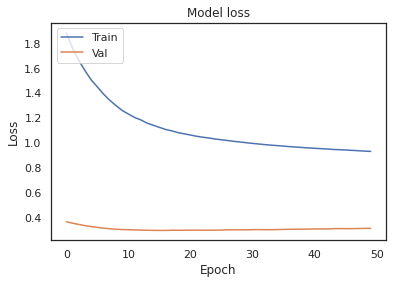

*** ANN estimation ***
MAPE:  15.424647821971881
R2:  0.8489280018338943
RMSE:  698.1462777638098


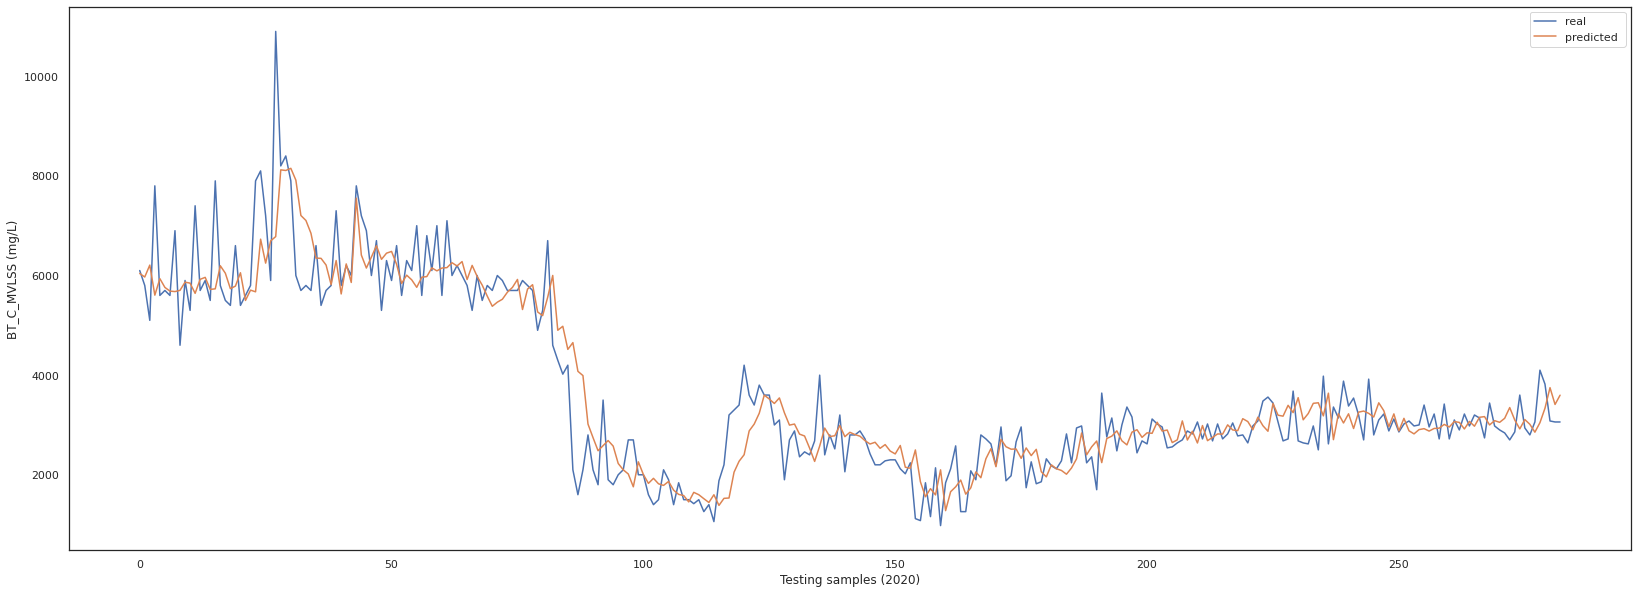

(283,)

In [100]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape


 ## Approach 2

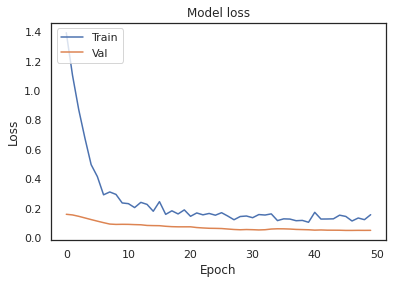

*** LSTM estimation ***
MAPE:  57.272766294231836
R2:  0.9125912865193739
RMSE:  531.0455870229191


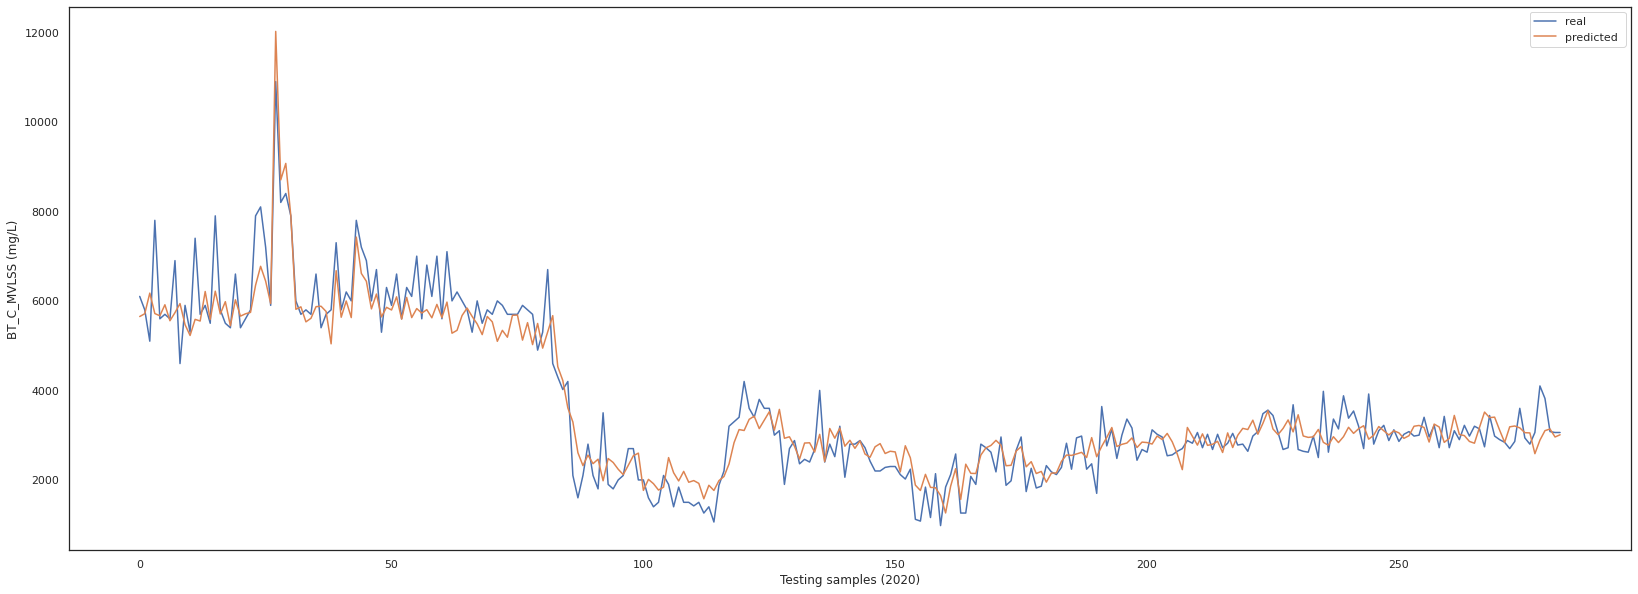

(283, 1)

In [101]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  17.134575138737482
R2:  0.822633164393584
RMSE:  756.4681529082214


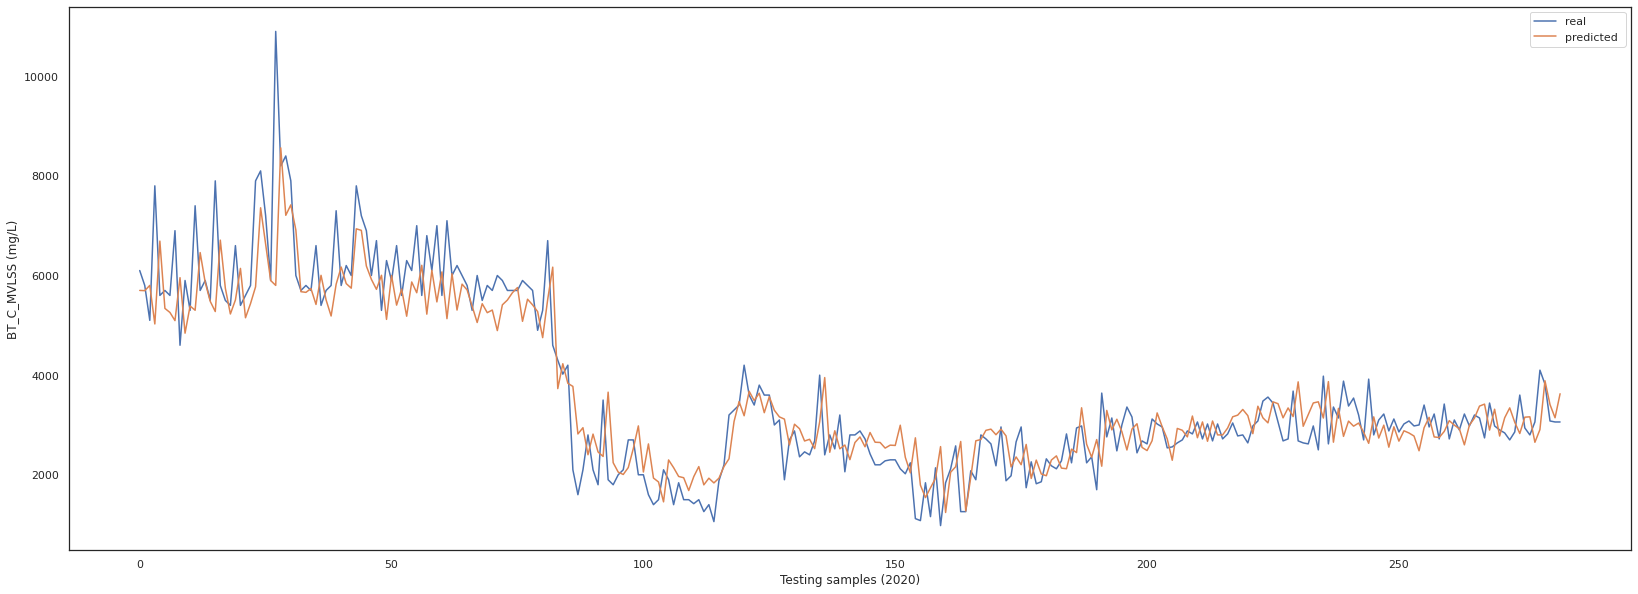

(283,)

In [102]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

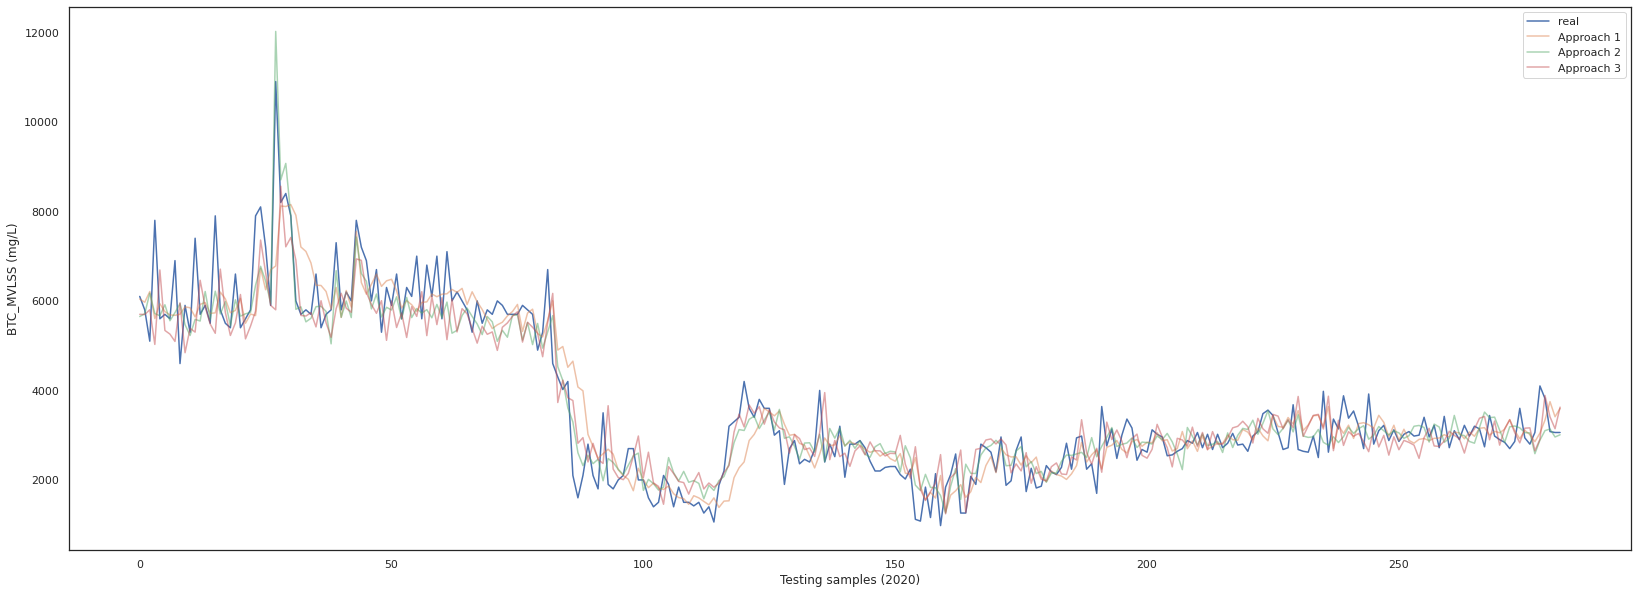

In [103]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [104]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      17391.822797
1      17379.130942
2      18184.806010
3      16350.332966
4      18294.905120
           ...     
278     8841.276812
279    10323.710921
280    10295.259589
281     9515.432271
282    10233.084779
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  15.687371888608023
R2:  0.8513471278903972
RMSE:  692.5339879740302


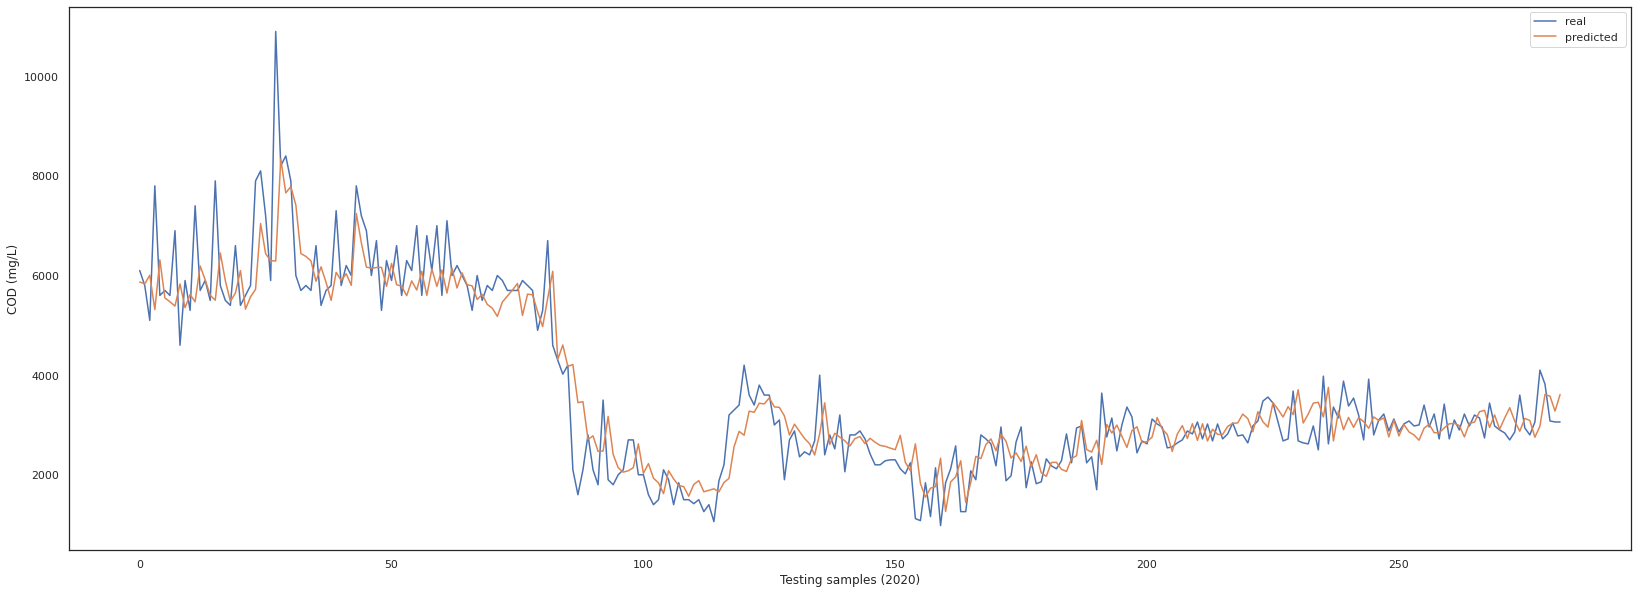

In [105]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  14.235964735476534
R2:  0.8885893680786043
RMSE:  599.5394413641604


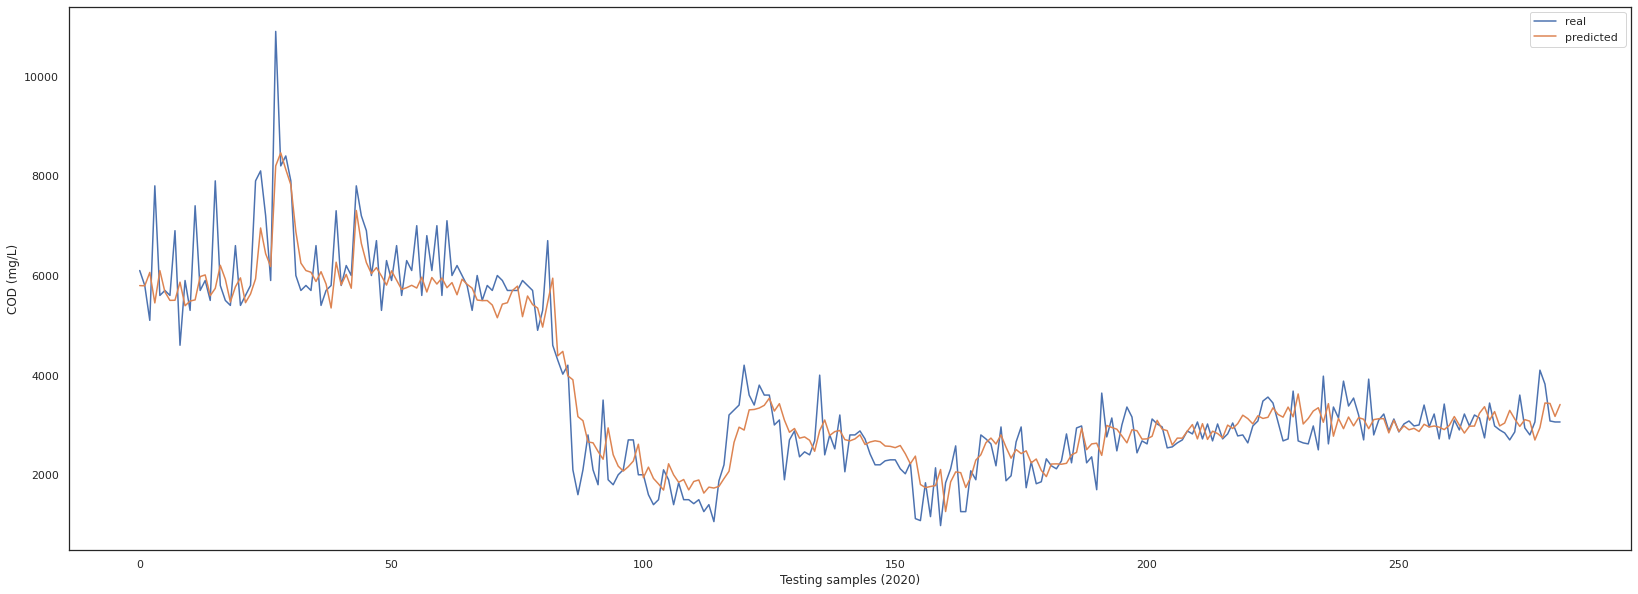

In [106]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [107]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7047 - MAPE: 128.6330 - val_loss: 0.1672 - val_MAPE: 111.5768
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5709 - MAPE: 121.9568 - val_loss: 0.1467 - val_MAPE: 102.9180
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4423 - MAPE: 115.1371 - val_loss: 0.1297 - val_MAPE: 94.7211
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3236 - MAPE: 110.1969 - val_loss: 0.1160 - val_MAPE: 87.1598
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2088 - MAPE: 104.7462 - val_loss: 0.1050 - val_MAPE: 80.3272
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0959 - MAPE: 99.5699 - val_loss: 0.0952 - val_MAPE: 74.8605
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9917 - MAPE: 95.4505 - val_loss: 0.0866 - val_MAPE: 72.4002
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss

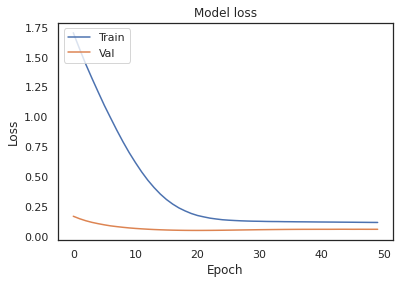

In [108]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[107.7387   107.62174  114.707985  98.123344 118.34594  103.948235
  99.67855   99.46516  109.96151   96.51853   99.59064   99.98754
 114.35935  113.53976  102.33623  105.57393  120.75403  111.06862
  98.89823  106.78451  112.52598   98.42653  103.06765  111.30617
 141.55687  126.049255 117.94571  144.82465  184.92311  173.00287
 164.94333  138.33716  119.36751  115.44537  114.70415  109.33684
 115.46824  108.19003   96.07834  120.10638  109.19836  113.7701
 106.48108  149.88553  132.00905  120.57184  114.326324 117.07566
 113.249115 106.96666  115.90809  110.00557  105.84726  105.76094
 108.20253  106.41335  112.98313  103.67966  112.640854 108.11267
 112.31736  105.65385  109.886505 102.47883  111.27498  108.42419
 105.85959   99.50601   99.86176   99.59626   97.58441   91.365974
  98.188896  99.00017  105.16177  107.58843   92.10923  102.2412
  97.97806   96.18482   87.19753   99.28789  112.40758   73.90874
  76.51039   61.014412  

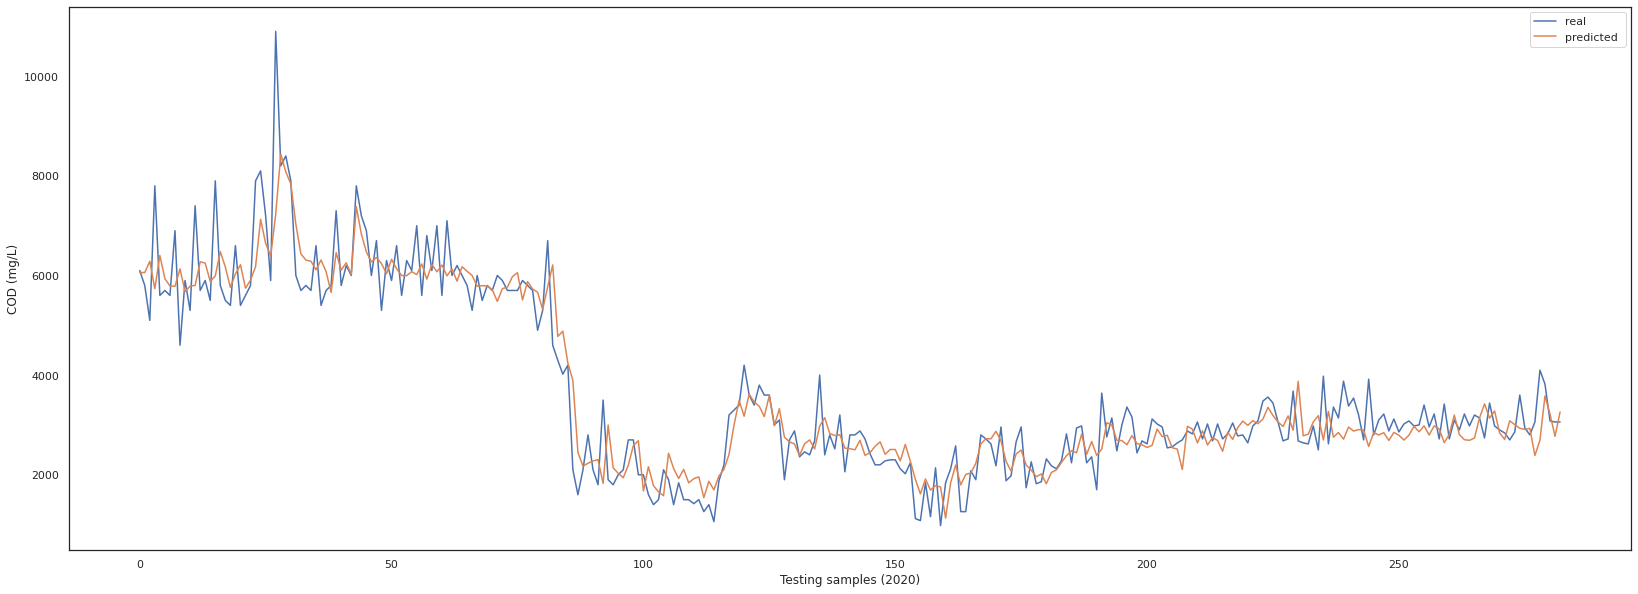

In [109]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [110]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 18ms/step - loss: 5.1081 - MAPE: 228.5624 - val_loss: 0.4062 - val_MAPE: 193.8093
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 4.7073 - MAPE: 214.9164 - val_loss: 0.3624 - val_MAPE: 180.3596
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 4.3272 - MAPE: 203.4033 - val_loss: 0.3230 - val_MAPE: 167.4035
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 3.9850 - MAPE: 191.1339 - val_loss: 0.2878 - val_MAPE: 156.0732
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 3.6663 - MAPE: 179.3033 - val_loss: 0.2569 - val_MAPE: 145.6024
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 3.3806 - MAPE: 168.8510 - val_loss: 0.2283 - val_MAPE: 135.0994
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 3.1228 - MAPE: 158.3190 - val_loss: 0.2027 - val_MAPE: 124.7830
Epoch 8/50
8/8 [==============================] - 0s 3ms/step

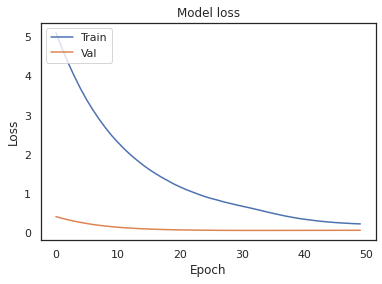

In [111]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 93.07789   97.92104   92.85773   78.74414  118.47      86.9777
  88.9439    85.159546 103.50336   69.62091   94.151085  84.6056
 114.24366   92.512856  93.77834   82.57464  121.2577    93.30771
  86.6365    85.953026 107.142746  83.783806  88.8863    92.39009
 127.43174  119.34297  111.89514   55.206413 162.3615   118.313095
 138.46025  136.15335   93.88638   91.68703   93.79356   88.45542
 106.9129    86.54917   90.27235   90.38225  108.31691   94.05082
  99.87571  101.27053  120.67528  109.05241  108.8601    93.97171
 108.75314   80.11086  103.32372   89.91243  102.15522   84.21139
 102.02575   96.93924  109.15627   85.89189  108.9582    94.06068
 109.860435  83.92747  112.38058   93.43915  100.63909   96.27475
  90.4183    81.90346   95.92814   86.22086   91.00406   87.204445
  94.686356  96.006874  92.81816   93.76195   89.28047   94.57799
  94.145744  89.748634  77.28125   88.3218   107.49459   61.814053
  68.025696  54.48583  

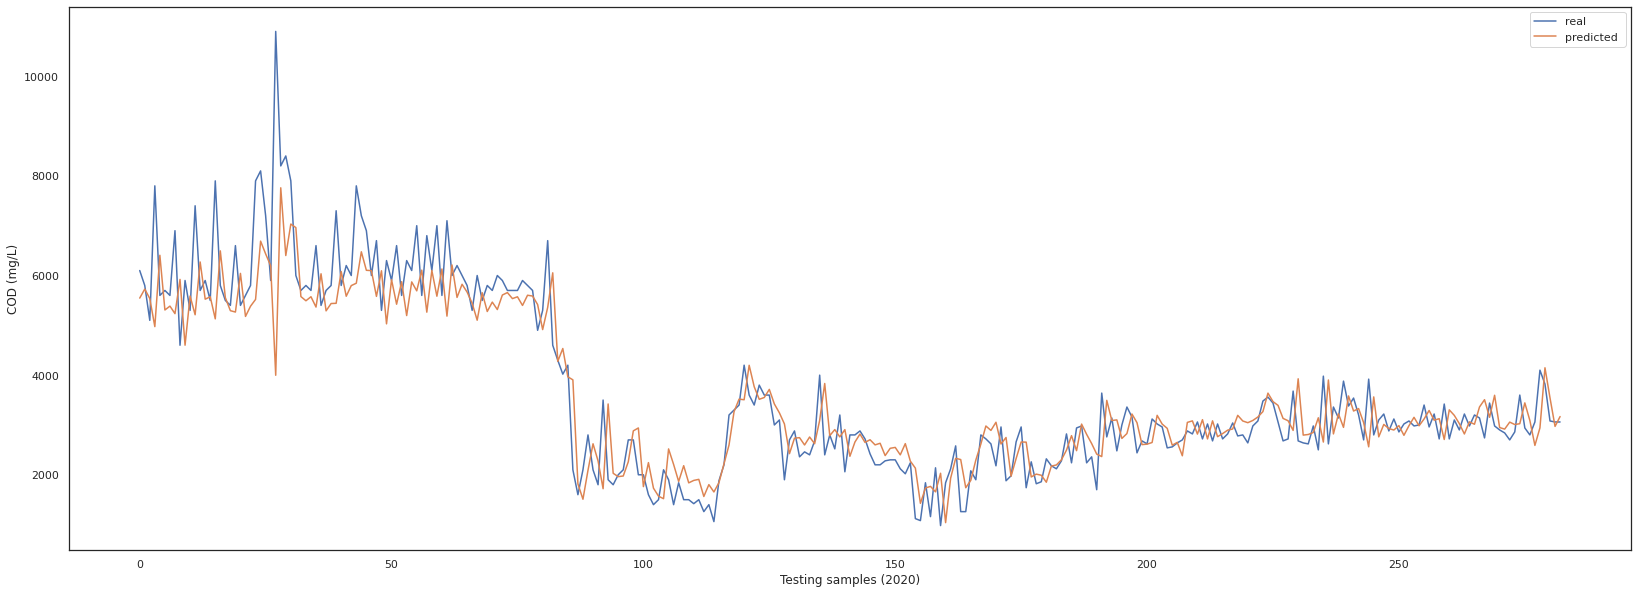

In [112]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [113]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    0  1  0
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  1  0
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 0s 20ms/step - loss: 1.3651 - accuracy: 0.2362 - val_loss: 1.1092 - val_accuracy: 0.4138
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2978 - accuracy: 0.2559 - val_loss: 1.1037 - val_accuracy: 0.4138
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.2453 - accuracy: 0.3071 - val_loss: 1.0993 - val_accuracy: 0.4138
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2017 - accuracy: 0.3228 - val_loss: 1.0959 - val_accuracy: 0.3793
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1687 - accuracy: 0.3268 - val_loss: 1.0933 - val_accuracy: 0.3793
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1462 - accuracy: 0.3307 - val_loss: 1.0

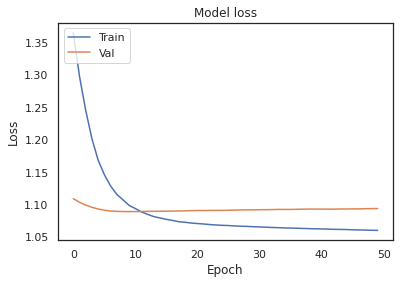

In [114]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

     BT_C_MVLSS    model1    model2    model3
0      1.104038  1.388749  1.237034  1.386936
1      1.325904  1.346678  1.276232  1.383747
2      1.159505  1.489301  1.564468  1.454944
3      0.771239  1.129588  1.278604  0.933383
4      2.268835  1.326879  1.247451  2.054330
..          ...       ...       ...       ...
278   -0.360277 -0.395711 -0.491209 -0.495770
279    0.216574 -0.223334 -0.358124  0.164992
280    0.061268  0.023265 -0.335400 -0.157588
281   -0.349184 -0.177599 -0.446898 -0.335858
282   -0.360277 -0.066654 -0.416021 -0.010944

[283 rows x 4 columns]      0  1  2
0    1  0  0
1    0  1  0
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  1  0
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
9/9 [==============================] - 0s 1ms/step - loss: 1.0634 - accuracy: 0.4134
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(13.890455727427447, shape=(), dtype=float64)
MAPEsci:  41771.14414718644
MAPE:  13.890455727427428
R2:  0.89

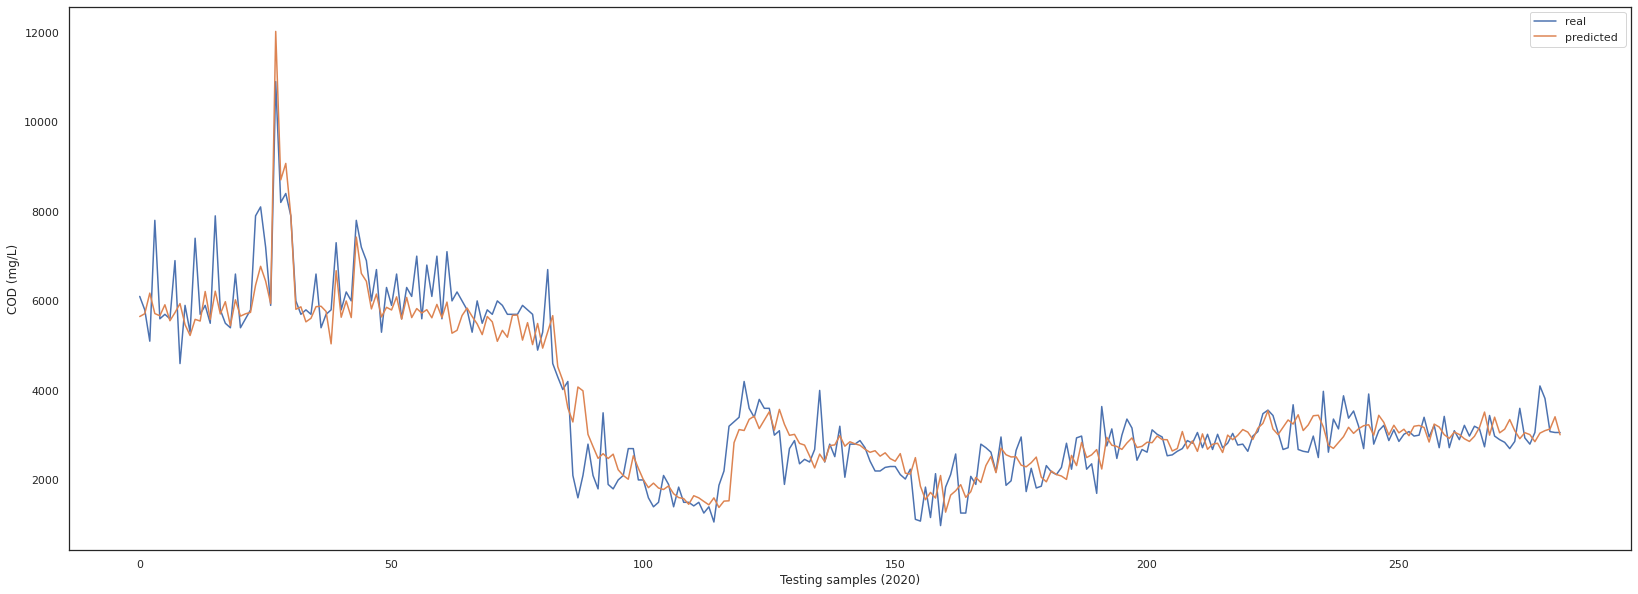

In [115]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [116]:
ensemble_model3.selection.to_list().count(1)

148

## Testing


*** ANN estimation ***
MAPE:  11.541218720716161
R2:  -0.39367437973221353
RMSE:  543.4943884001831


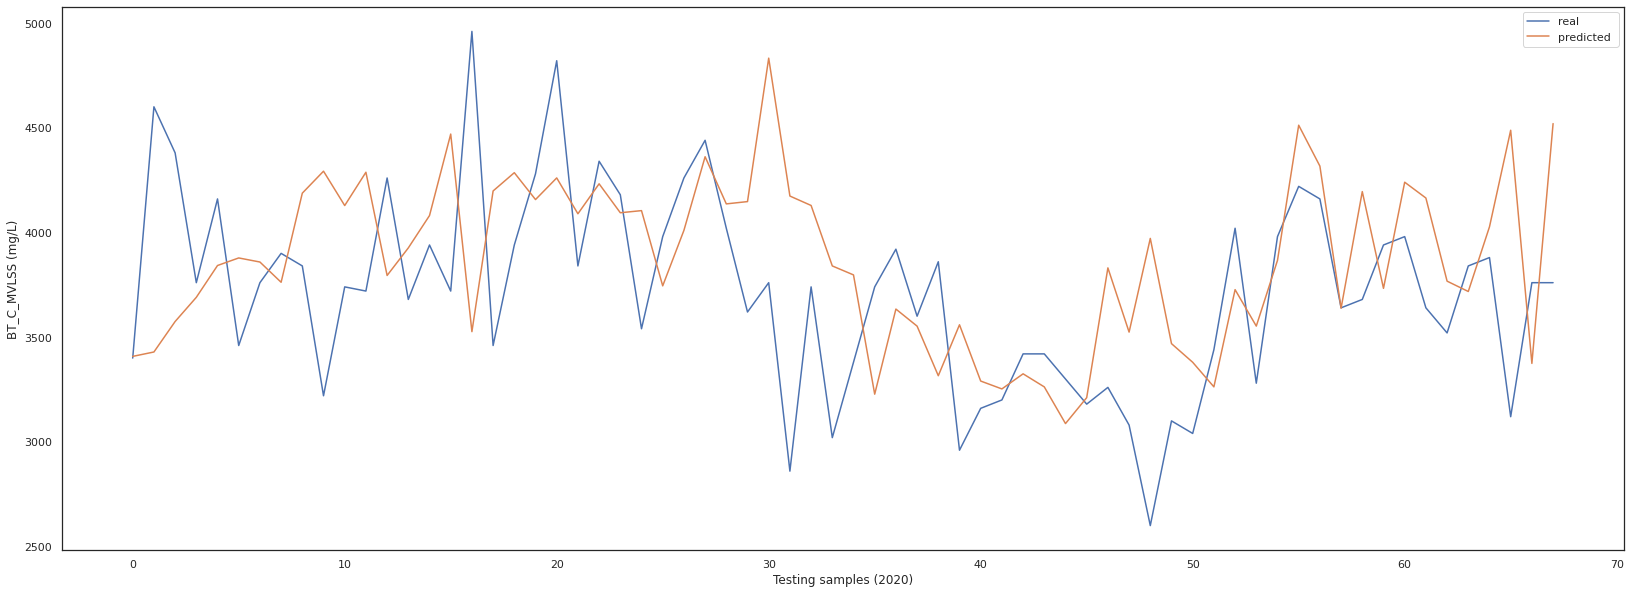

(68,)

In [117]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  17.82383292381999
R2:  -1.8261901318817295
RMSE:  773.9539017081942


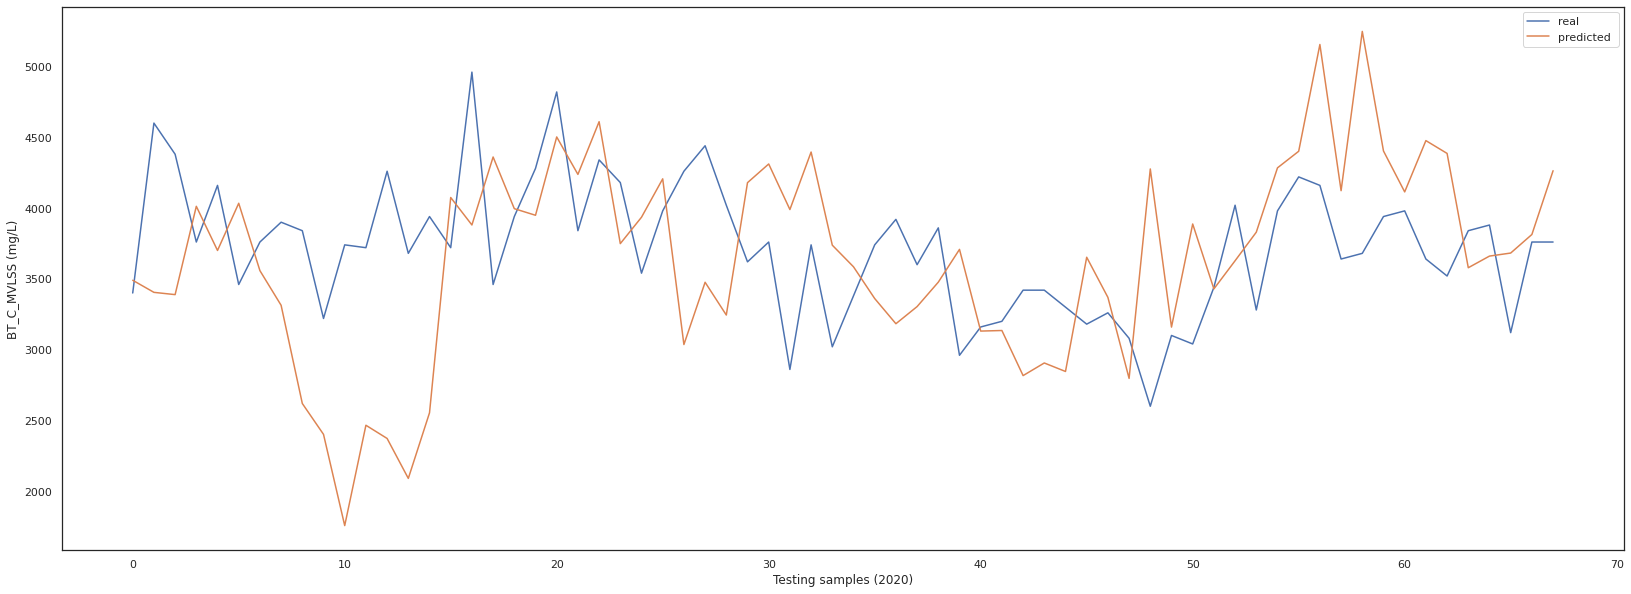

(68, 1)

In [118]:
app2.testing(dataset.iloc[-(cut_off+2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  13.400678591634453
R2:  -0.8481247829045686
RMSE:  625.8641154872084


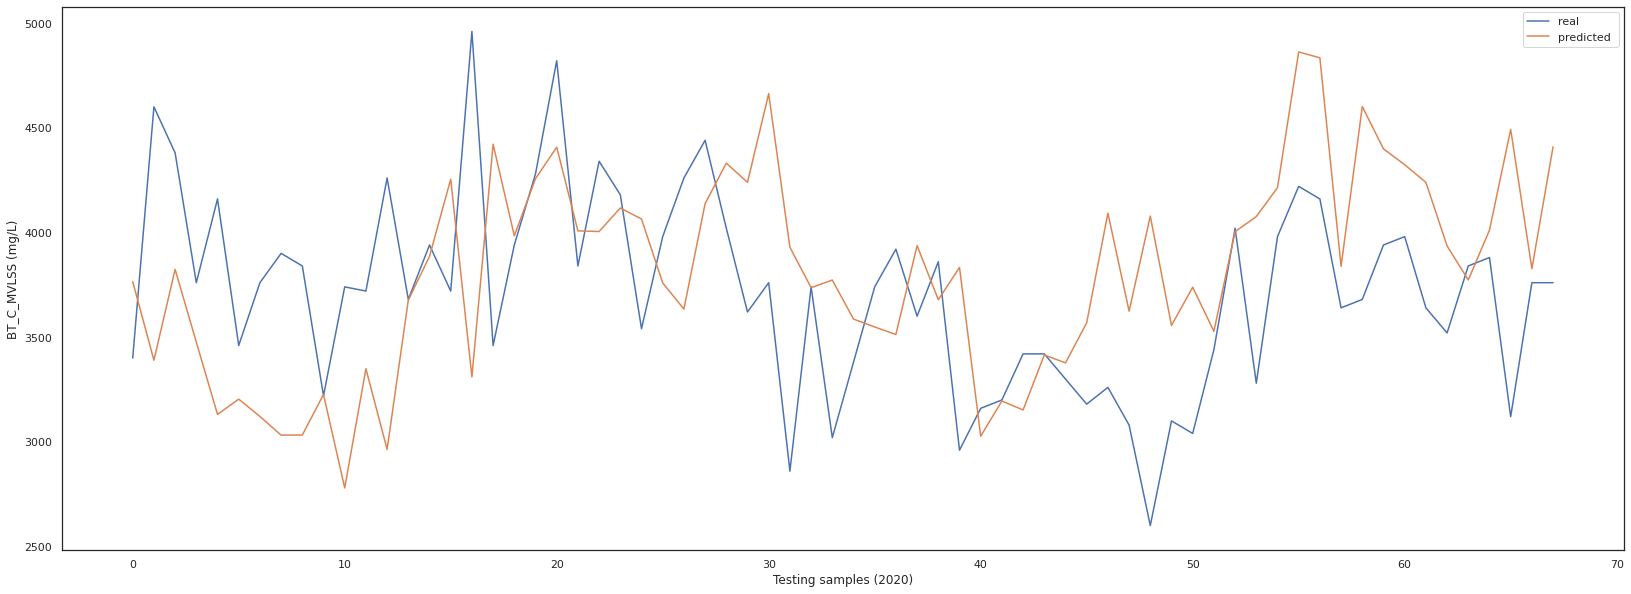

(68,)

In [119]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  12.403025892052465
R2:  -0.5332555555498502


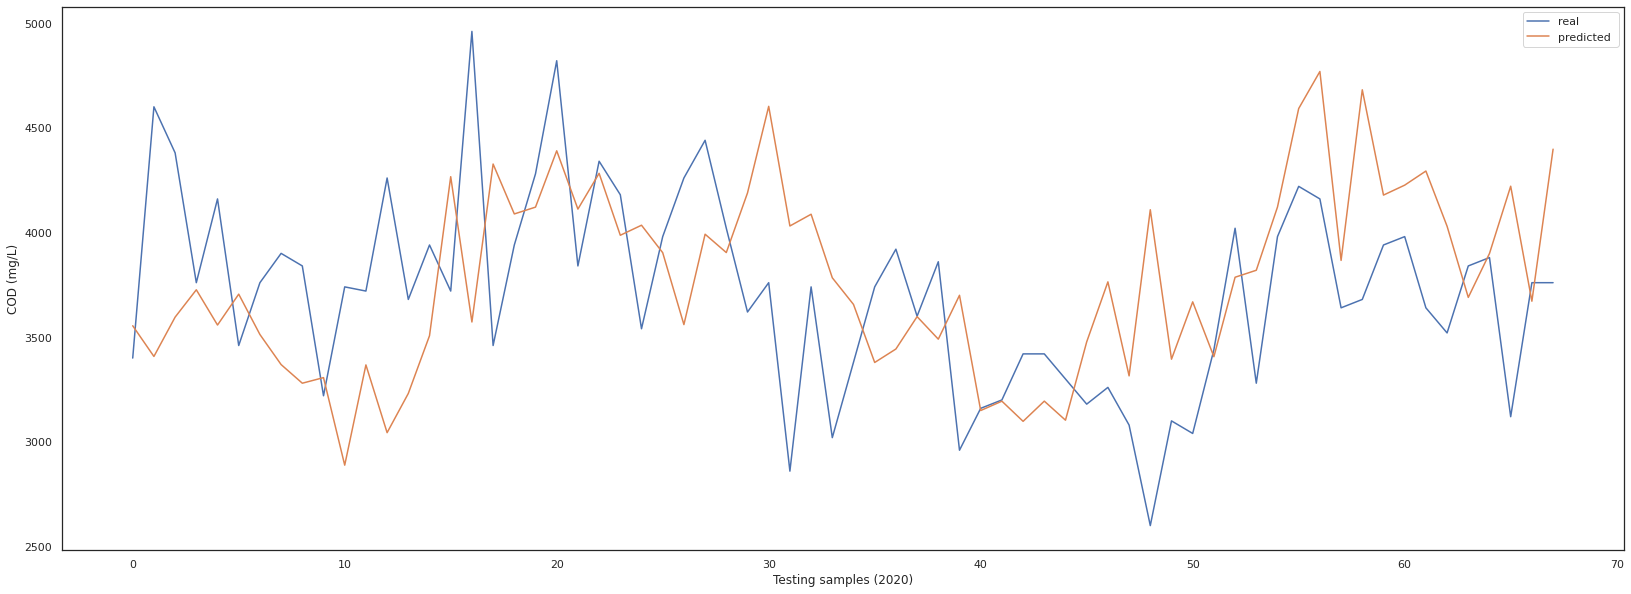

In [120]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.989546 13.239269 10.162018 12.03721  10.800176 11.037755 12.075511
 17.124521 29.724232 32.668266 57.775414 28.199886 39.61107  31.452864
 15.618619 28.958904  9.937697 30.518621 24.730345 25.824625 31.864244
 24.185478 26.073765 22.78145  23.712742 16.775898 12.155717 19.474134
 16.945284 27.25367  37.000698 23.434053 20.557165 14.943011 10.04737
 11.589554 12.537914 10.332068 10.115237 13.622772 21.497007 19.68931
 27.186537 19.02944  20.699856 10.050959 13.697809 16.928894 23.971766
 12.828989 12.838164 11.340223 16.78662  19.002474 24.909477 37.079437
 41.03122  16.744703 35.84553  26.42674  28.189003 28.932793 19.59201
 11.81102  19.395678 28.343979 13.621563 32.042892], shape=(68,), dtype=float32)
MAPEsci:  72718.0071662454
MAPE:  21.27063045261518
R2:  -2.6431691986427377
RMSE:  878.7272145968633


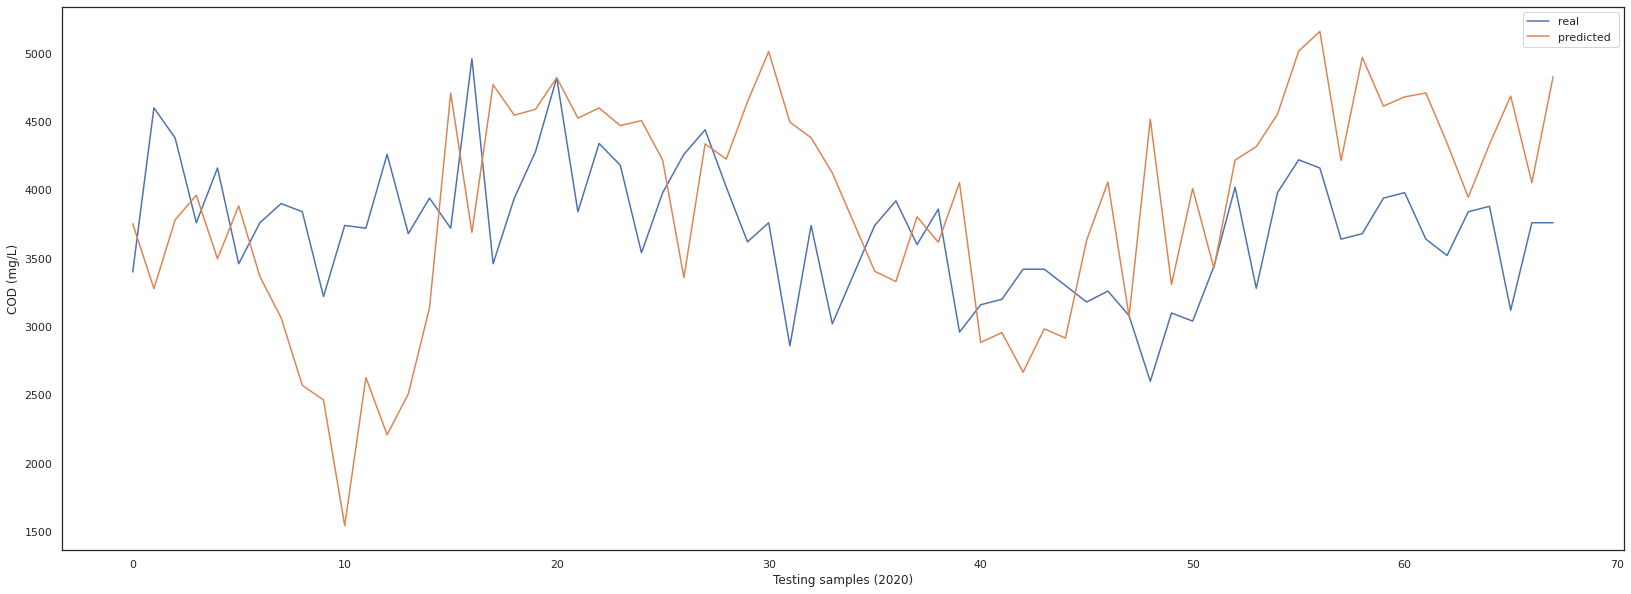

In [121]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[18.155642  10.904227  24.705414  19.670633  10.426373  12.677558
 13.269154  12.385589  19.27376   18.67275   43.65833   17.968355
 22.248573   9.984327  11.120012  20.86752   10.546458  33.818848
 10.079496  21.89471   25.933891  28.79361   15.5781    26.782959
 23.587708  14.143764   9.923084  20.305992  26.881084  22.477207
 20.544386  13.206546  10.247623  11.6550255 12.883083  10.187164
 10.185331  14.838841  10.349259  15.481621  19.666513  14.758551
 18.193045  12.919763  12.947289   9.927854  10.411484  14.889927
 12.161079  19.347368  10.373086  11.477476  10.572256  23.007462
 15.342633  27.581135  27.078566  20.630613  20.039055  19.80826
 22.623617  20.673313  16.250551   9.926147  14.400345  19.488045
 10.260504  20.405365 ], shape=(68,), dtype=float32)
MAPE:  17.227577949507804
R2:  -1.140474704300876
RMSE:  673.5494038005734


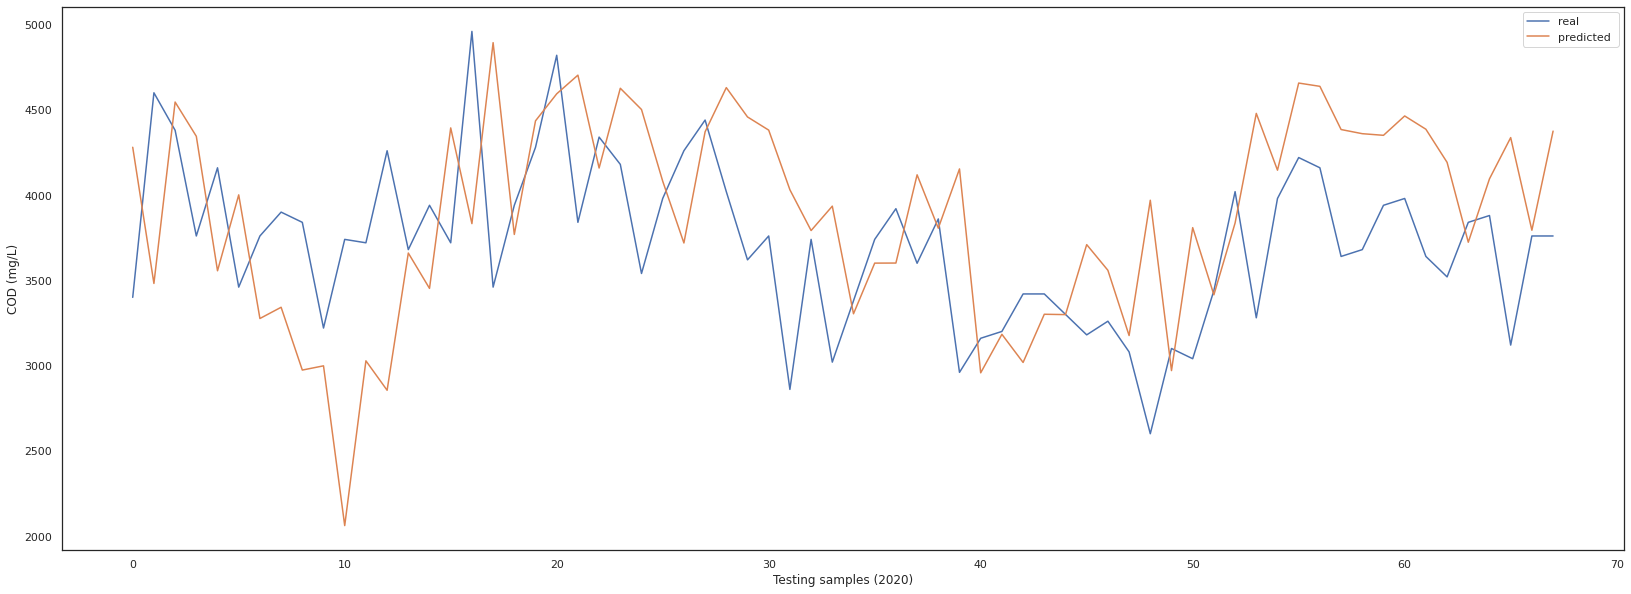

In [122]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

    BT_C_MVLSS    model1    model2    model3
0     0.238761 -0.179758 -0.114981  0.082495
1    -0.171691 -0.167265 -0.168417 -0.170487
2     0.493907 -0.080571 -0.178464  0.121870
3     0.371880 -0.011695  0.211830 -0.112389
4     0.027988  0.078835  0.016672 -0.344813
..         ...       ...       ...       ...
63   -0.105132  0.004880 -0.059607  0.087840
64    0.072361  0.188910 -0.008168  0.248366
65    0.094548  0.463697  0.005268  0.572531
66   -0.326998 -0.199760  0.087285  0.124223
67    0.027988  0.482640  0.369164  0.516765

[68 rows x 4 columns]      0  1  2
0    1  0  0
1    0  1  0
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  1  0
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
3/3 [==============================] - 0s 4ms/step - loss: 1.1253 - accuracy: 0.2353
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(16.42124891387962, shape=(), dtype=float64)
MAPEsci:  60129.02393180783
MAPE:  16.421248913879623
R2:  -1.574191379017201

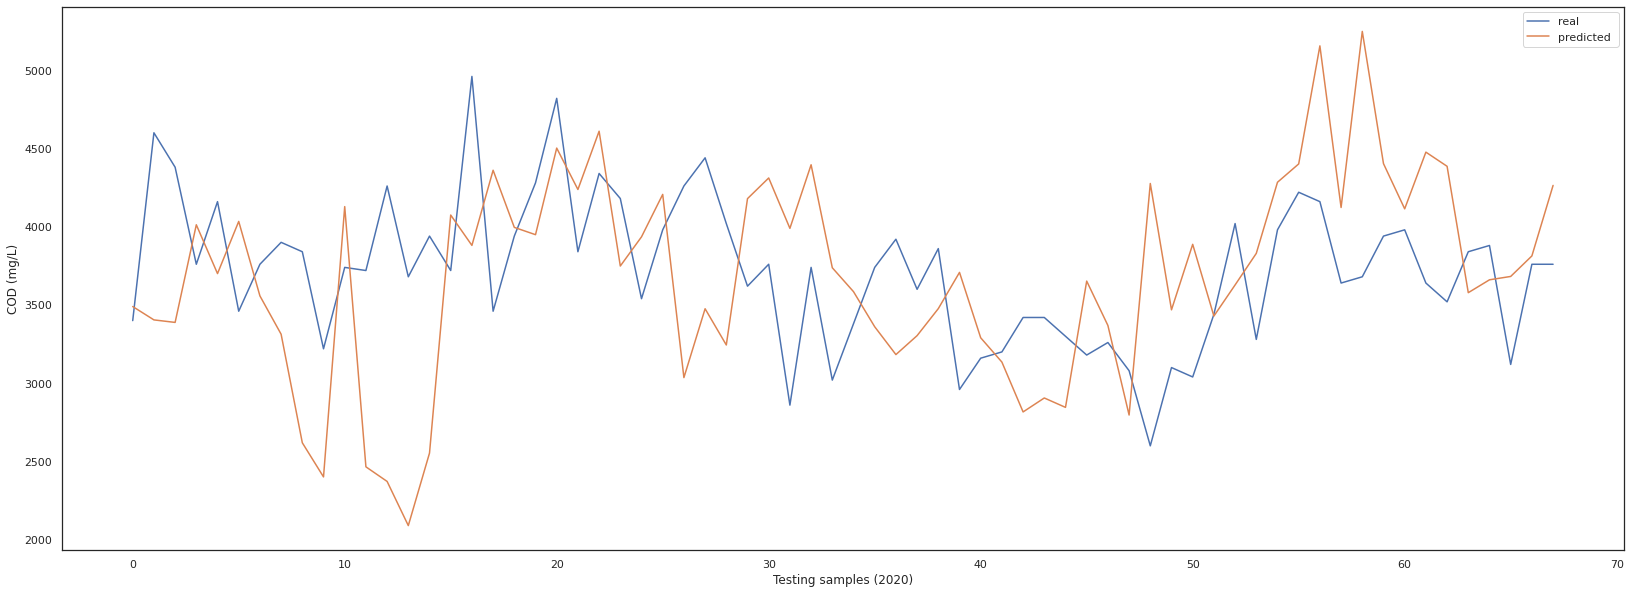

In [123]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [124]:
ensemble_model3.selection.to_list().count(3)

0

# EQ_COD

In [68]:
active_target = "EQ_COD"
dataset = dataset2.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

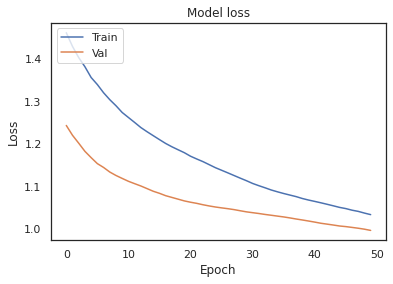

*** ANN estimation ***
MAPE:  7.841107703767819
R2:  0.17198701750619916
RMSE:  38.44870400711376


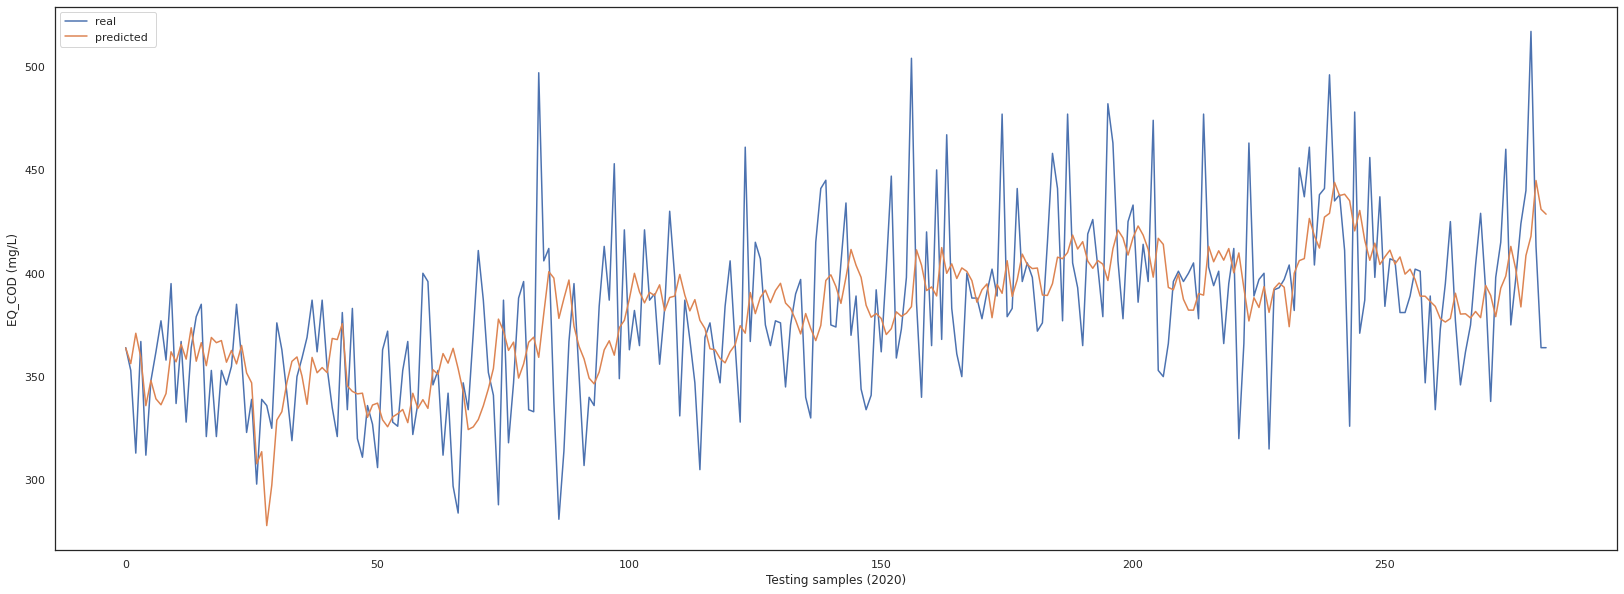

(283,)

In [69]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

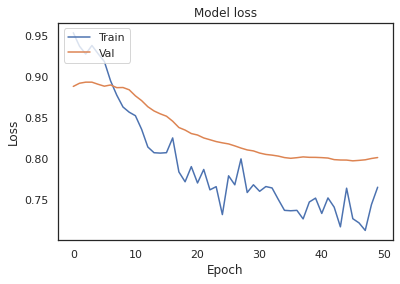

*** LSTM estimation ***
MAPE:  9.641905705577148
R2:  0.2770083355347053
RMSE:  35.92772994350818


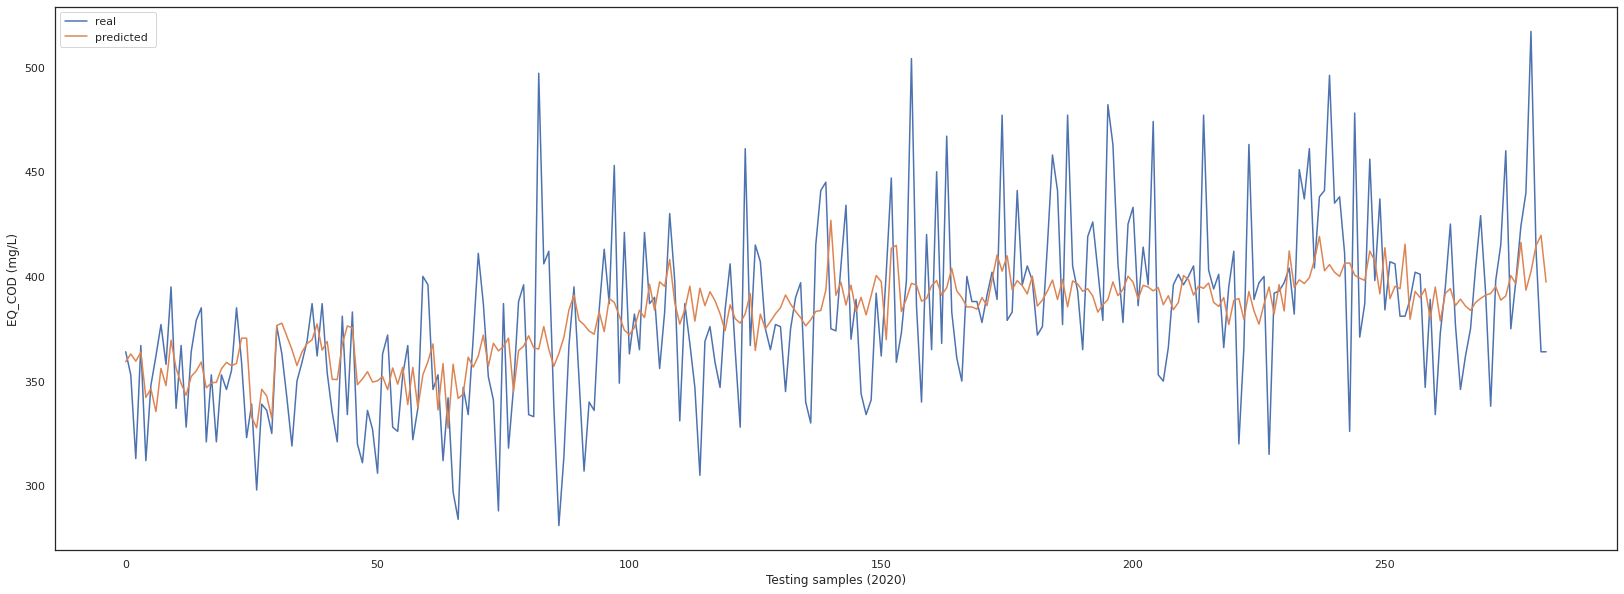

(283, 1)

In [70]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  7.33404885654958
R2:  0.23912289885811888
RMSE:  36.85703453175558


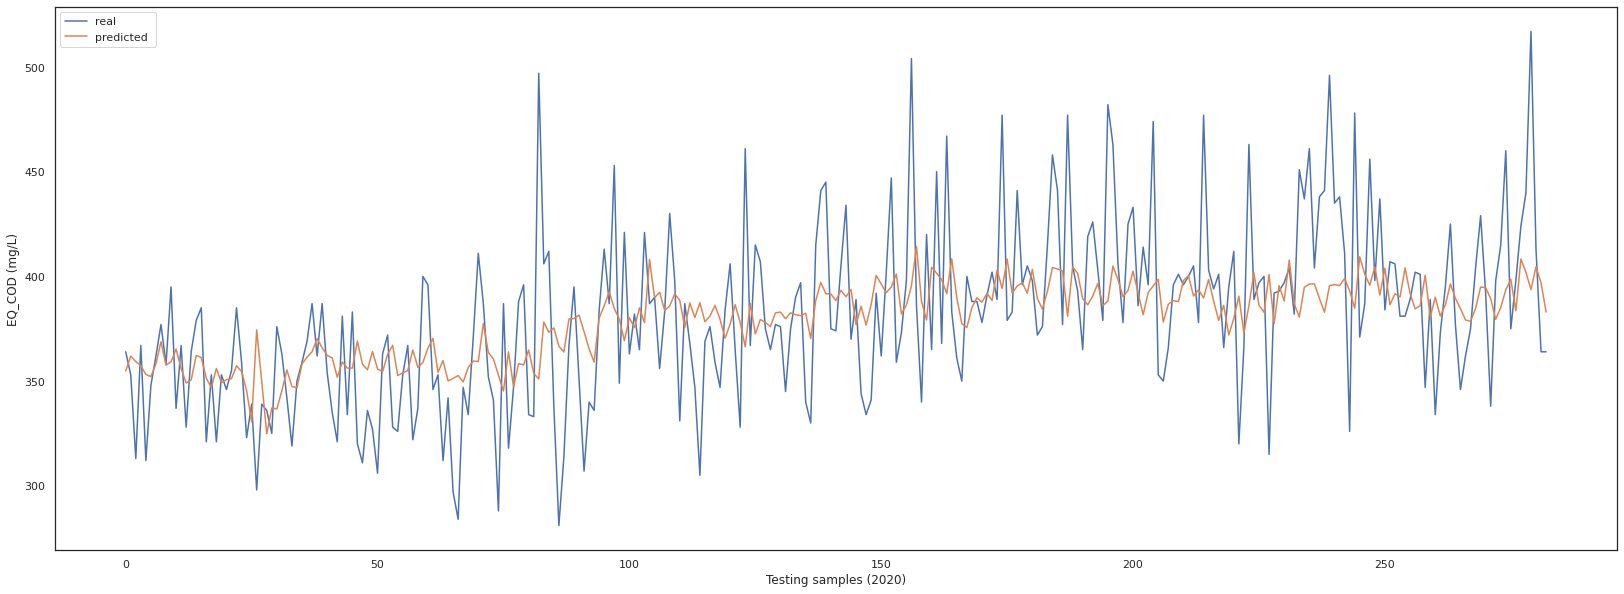

(283,)

In [71]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

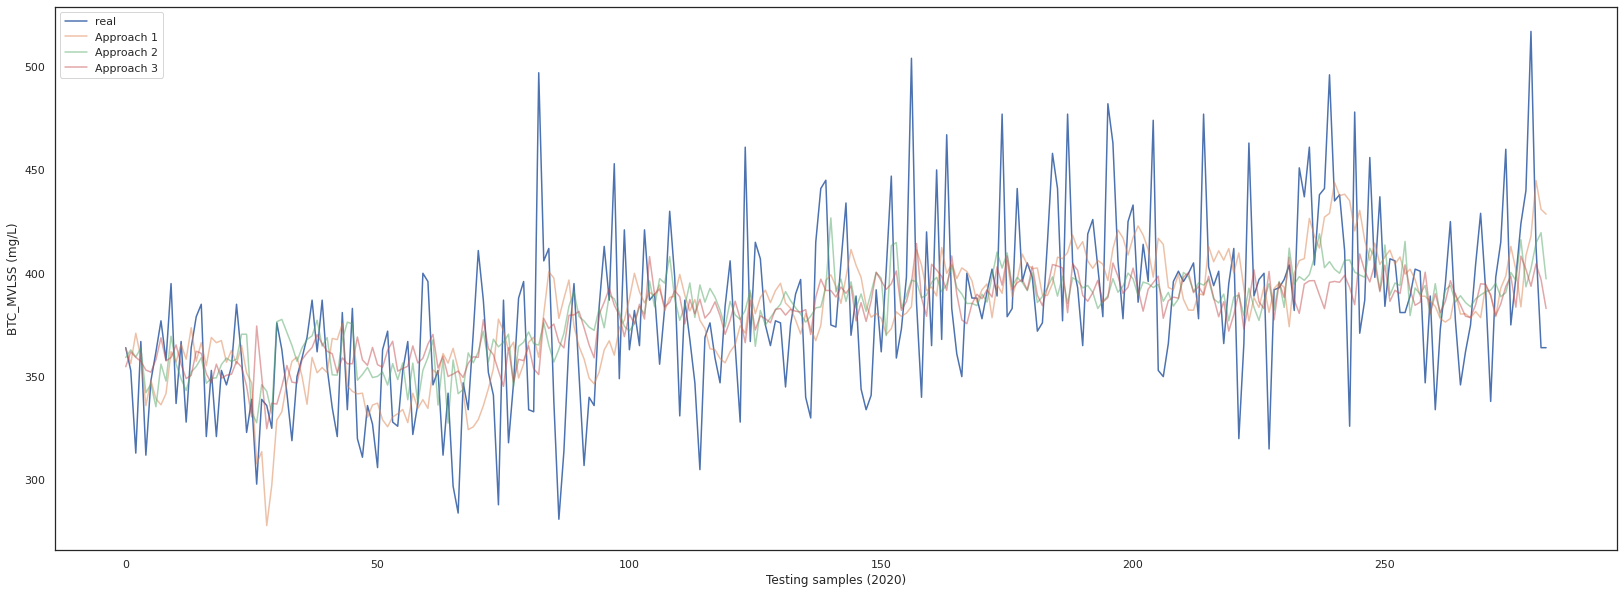

In [72]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [73]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      1077.873035
1      1081.198538
2      1089.808500
3      1080.469430
4      1031.344392
          ...     
278    1203.942258
279    1213.921618
280    1263.991664
281    1247.536122
282    1208.818541
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  7.345179233951649
R2:  0.2522789048221332
RMSE:  36.53700538550991


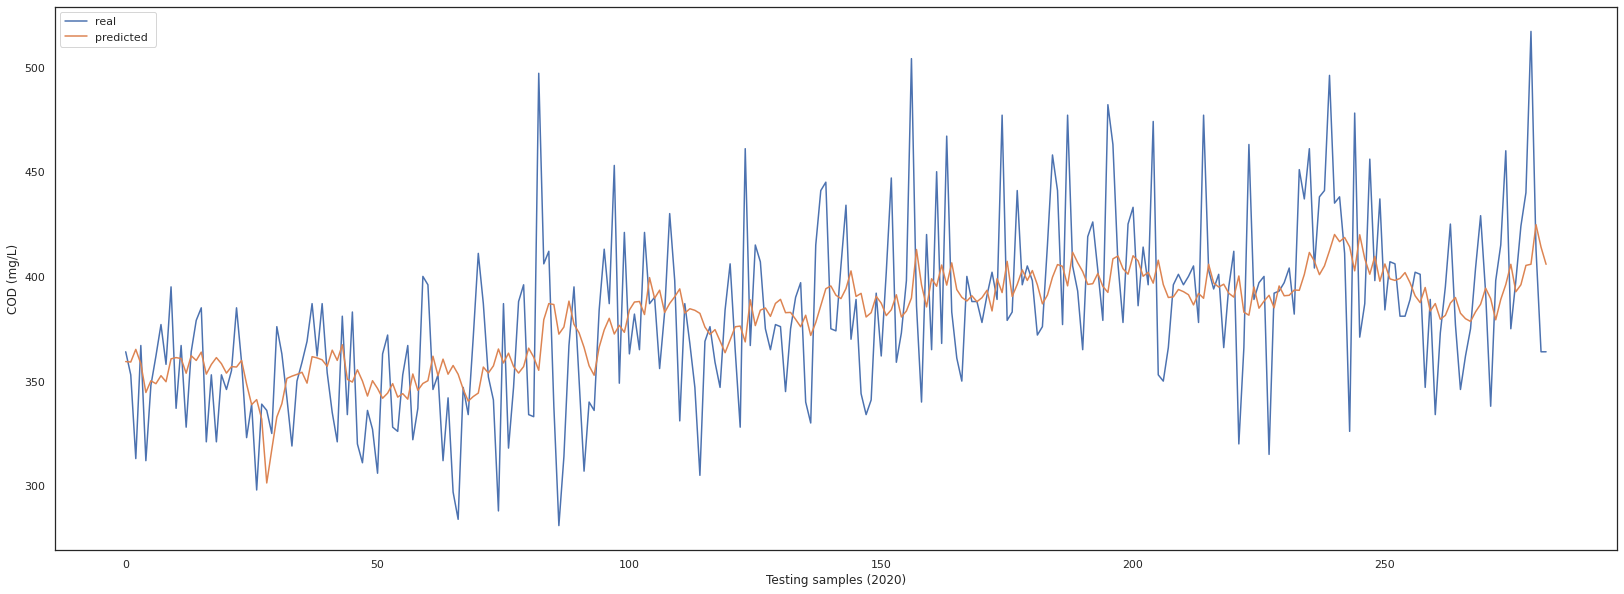

In [74]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  7.2127180015989865
R2:  0.2755744386799648
RMSE:  35.963339718674604


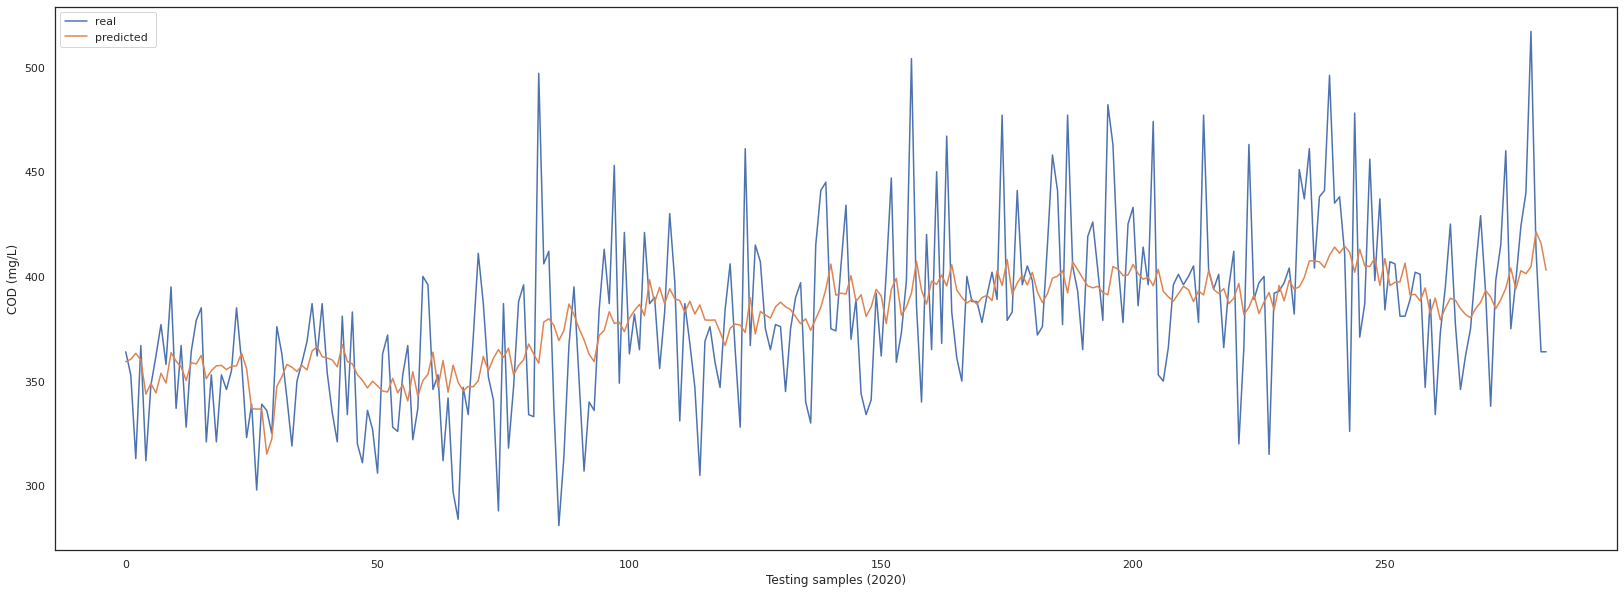

In [75]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [76]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 17ms/step - loss: 1.7950 - MAPE: 246.0748 - val_loss: 0.8446 - val_MAPE: 127.7242
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.6269 - MAPE: 222.4899 - val_loss: 0.8424 - val_MAPE: 141.2372
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4730 - MAPE: 193.8689 - val_loss: 0.8401 - val_MAPE: 157.3387
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3476 - MAPE: 184.3595 - val_loss: 0.8381 - val_MAPE: 173.1740
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2359 - MAPE: 170.7562 - val_loss: 0.8344 - val_MAPE: 191.4167
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1375 - MAPE: 159.0485 - val_loss: 0.8300 - val_MAPE: 208.3342
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0605 - MAPE: 149.5644 - val_loss: 0.8255 - val_MAPE: 224.8369
Epoch 8/50
8/8 [==============================] - 0s 3ms/step

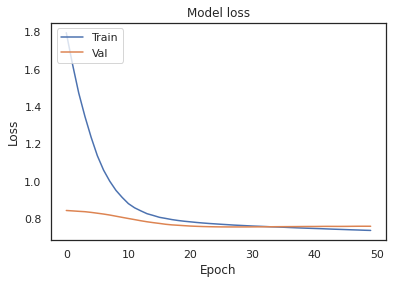

In [77]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.749904   9.7126465  9.208319   9.914107  10.617192  10.224571
  9.816701   9.883093  10.170734   9.851589   9.277912   9.3086
  9.858205   9.413799   9.408824   9.252276   9.953575   9.741761
  9.290277   9.859976  10.366197   9.989471   9.883038  10.077752
 11.681674  11.70151    9.830157  12.614879  19.587252  14.859126
 14.405545  12.77499   10.900155  10.886415  10.481021  10.293963
 10.656635   9.658234   9.365093   9.593006  10.062298   8.992009
  9.5197     9.268231  10.82049   10.932472   9.415856  10.23899
 11.292319  10.004444  10.647311  11.351479  10.505005  10.303125
 11.181083  11.299106  10.779805   9.924754  10.214896  10.413396
 10.313142   9.38102    9.62358    9.517522   9.406133   9.959189
  9.767408  10.618807  11.813213  11.275973  11.2487755  9.2745695
  9.934369  10.07749    9.465254  10.310535   9.5517025  9.683968
 10.35517   10.137073   9.375383   9.800763  10.460675   8.610107
  8.848481   8.8631935  8.

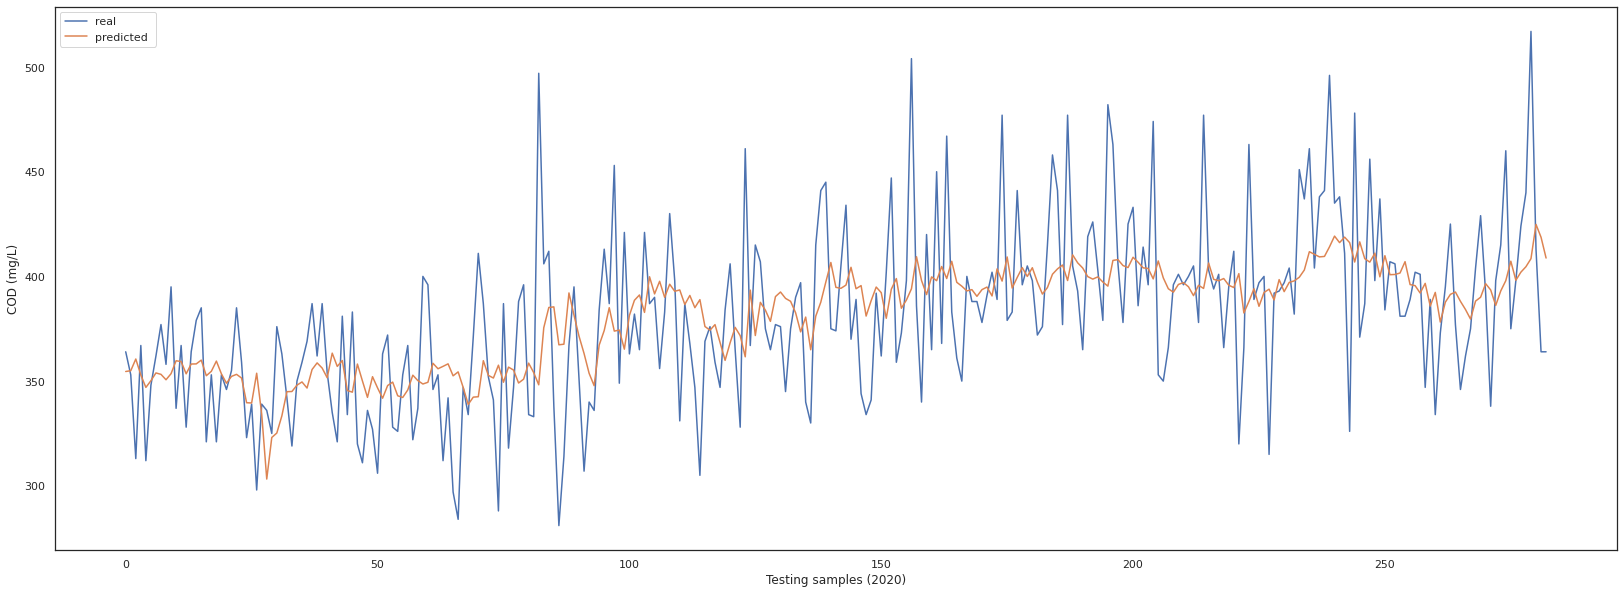

In [78]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [79]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7272 - MAPE: 347.5873 - val_loss: 2.2506 - val_MAPE: 1433.5728
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.6355 - MAPE: 324.3338 - val_loss: 2.1288 - val_MAPE: 1344.5391
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5506 - MAPE: 305.1595 - val_loss: 2.0173 - val_MAPE: 1259.1238
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4795 - MAPE: 289.0018 - val_loss: 1.9139 - val_MAPE: 1178.0951
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4152 - MAPE: 275.9200 - val_loss: 1.8225 - val_MAPE: 1101.3064
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.3551 - MAPE: 270.6108 - val_loss: 1.7415 - val_MAPE: 1030.1943
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3027 - MAPE: 259.0001 - val_loss: 1.6705 - val_MAPE: 964.9855
Epoch 8/50
8/8 [==============================] - 0s 3m

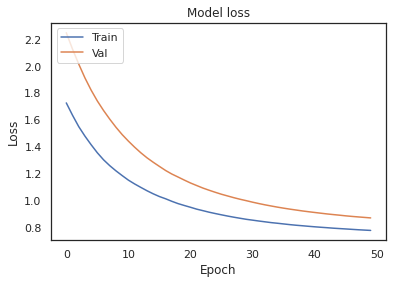

In [80]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.605779   9.084897   9.097329   9.519165  11.895071  11.61711
 13.049832  10.137406  10.747437   8.741514   9.296703  10.300182
 10.870404   9.860061   9.668645   9.026816  10.364747  10.402803
 10.043537   9.787529   9.515329   9.55858    9.519688   8.724875
  8.954623  13.878162  16.245514  14.389823  16.34987   16.592112
  9.651192   8.94329    8.86684    9.149683   9.901613   9.279311
  9.259577   8.720366   8.611654   9.003784   8.796893   9.808729
 10.087881   8.7878475  8.72265    9.037212  10.536103  11.141826
 11.71974   11.244566  11.334522  12.201541  11.793266  10.203179
 11.774718  10.836492  13.046082   9.89907   13.490404  10.74051
  9.643544   8.7445545 12.395189   9.3998    14.235425   9.5090275
 12.246909  13.003692  10.3819275 11.120005   9.801526   8.747051
  9.621895   8.910208   8.81645    9.285114   8.66024   10.998693
  9.271124   8.859615   8.630939   8.900109   9.142993   8.6932955
  8.620353   8.685638   

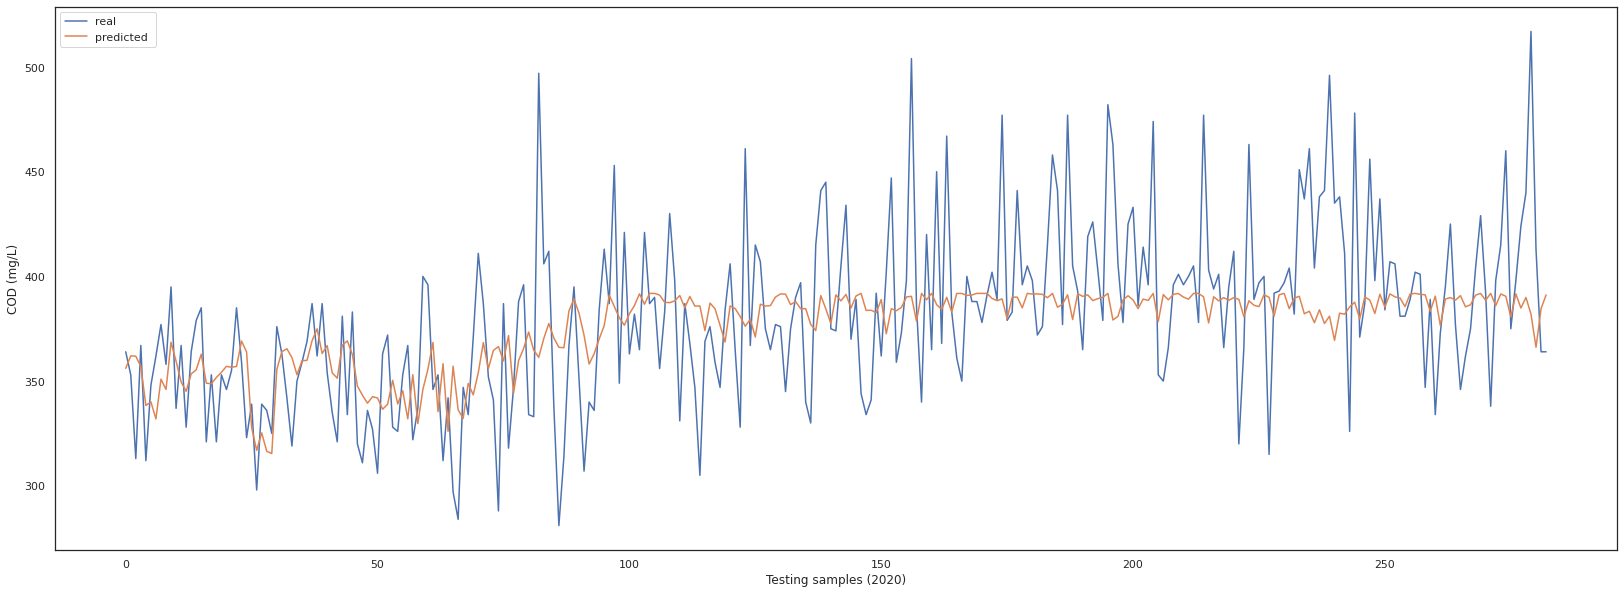

In [81]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [82]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    1  0  0
2    0  0  1
3    0  1  0
4    1  0  0
..  .. .. ..
278  1  0  0
279  1  0  0
280  0  1  0
281  0  0  1
282  0  0  1

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 0s 20ms/step - loss: 1.1228 - accuracy: 0.3465 - val_loss: 1.1020 - val_accuracy: 0.4138
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1111 - accuracy: 0.3504 - val_loss: 1.1004 - val_accuracy: 0.4138
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1064 - accuracy: 0.3622 - val_loss: 1.0992 - val_accuracy: 0.4138
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0997 - accuracy: 0.3740 - val_loss: 1.0984 - val_accuracy: 0.3793
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0976 - accuracy: 0.3780 - val_loss: 1.0976 - val_accuracy: 0.4138
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0944 - accuracy: 0.3622 - val_loss: 1.0

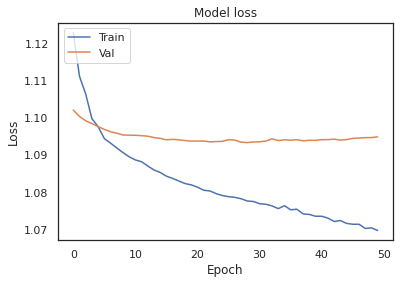

In [83]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

9/9 [==============================] - 0s 1ms/step - loss: 1.0715 - accuracy: 0.3922
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(7.627358196451301, shape=(), dtype=float64)
MAPEsci:  2891.6588564605872
MAPE:  7.627358196451301
R2:  0.22190817789219608
RMSE:  37.27164473935532


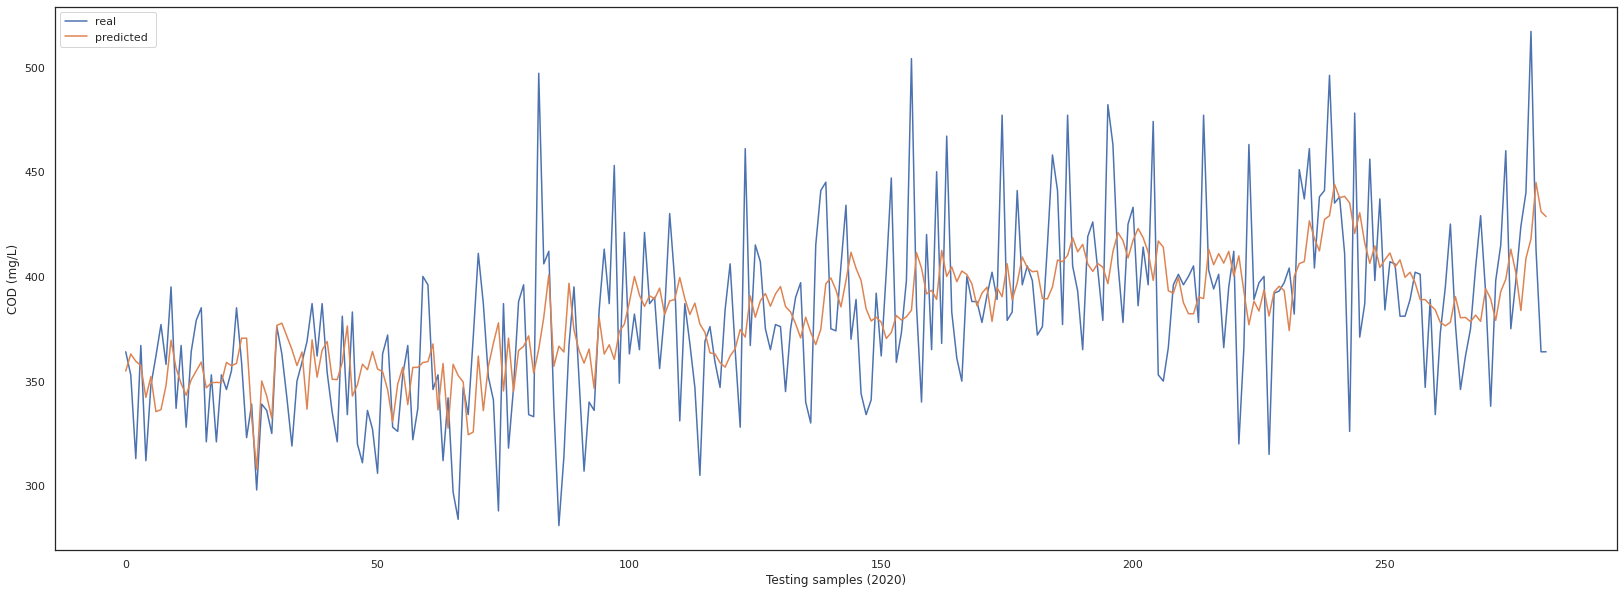

In [84]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [85]:
ensemble_model3.selection.to_list().count(1)

56

### Ensemble 4

In [86]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [87]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  13.639985489596729
R2:  -0.3536098987641261
RMSE:  59.767942639443625


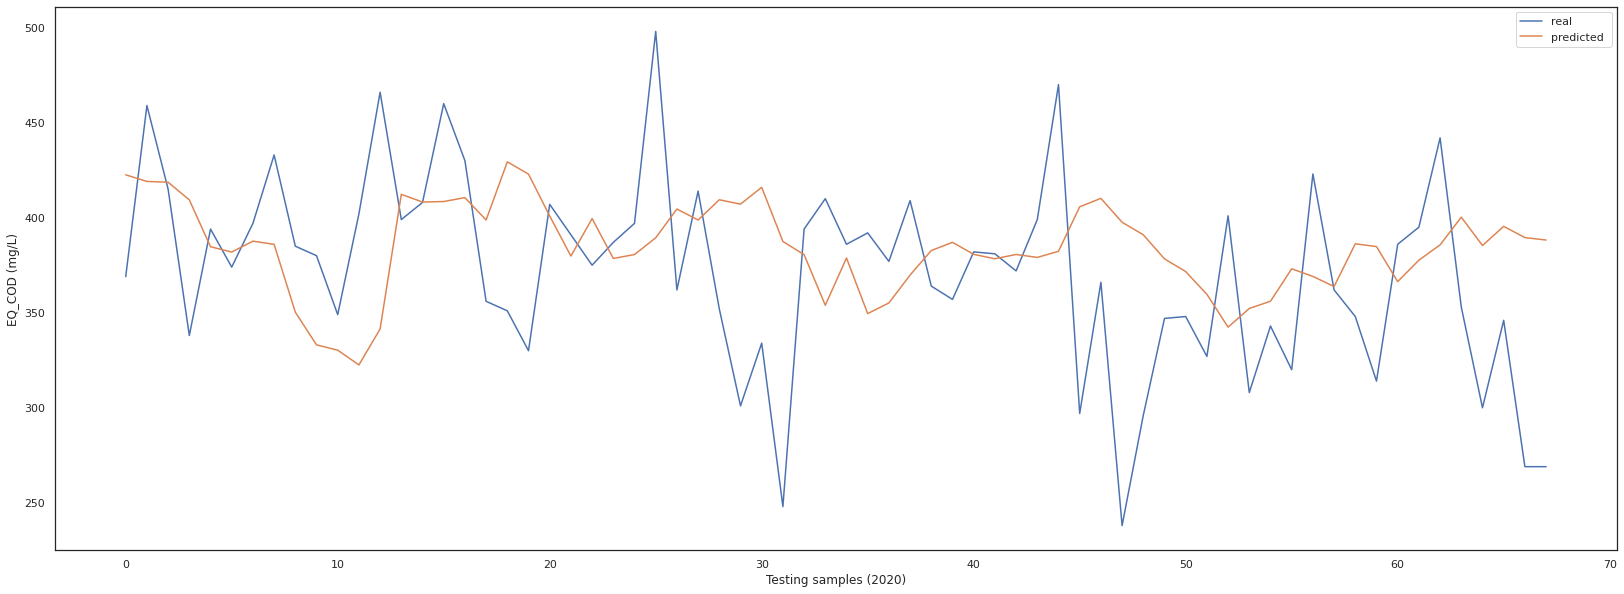

(68,)

In [88]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  12.192294121303657
R2:  0.04345800396483501
RMSE:  50.24276904647202


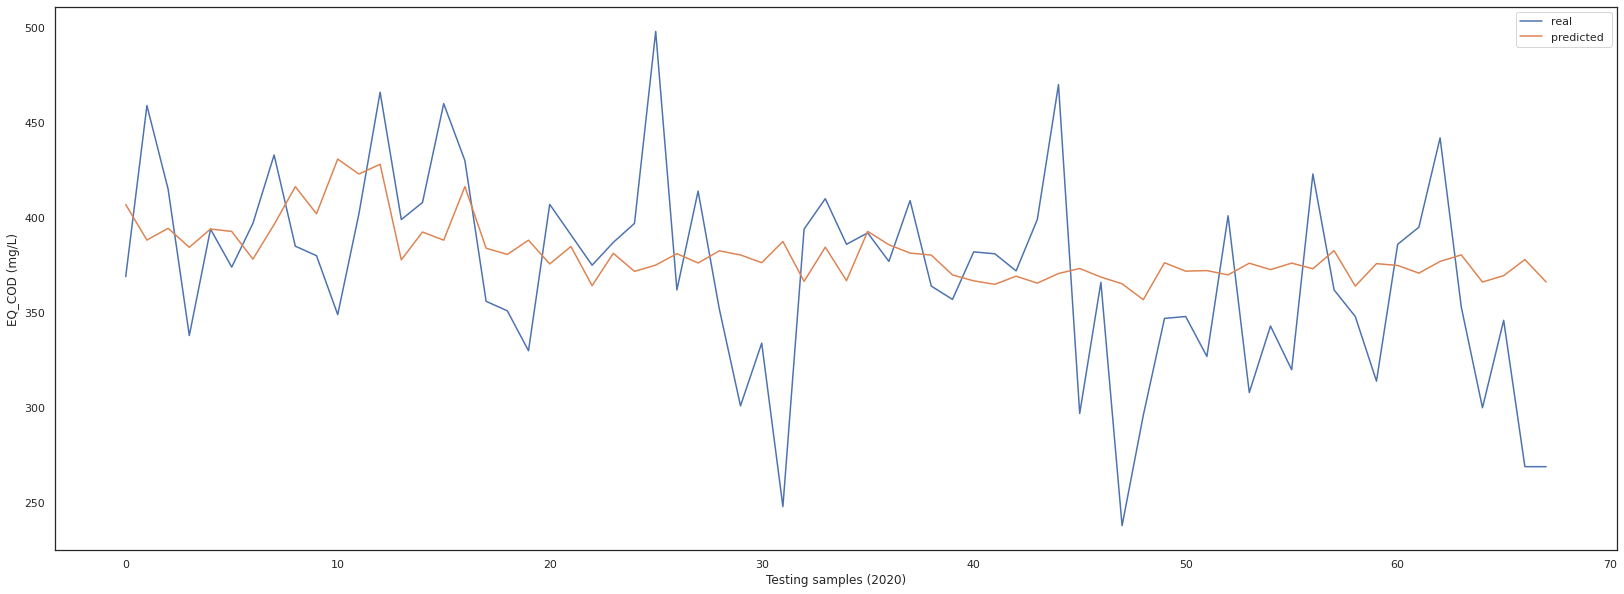

(68, 1)

In [89]:
app2.testing(dataset.iloc[-(cut_off + 2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  11.199959651560212
R2:  0.05091805057890619
RMSE:  50.046464517047326


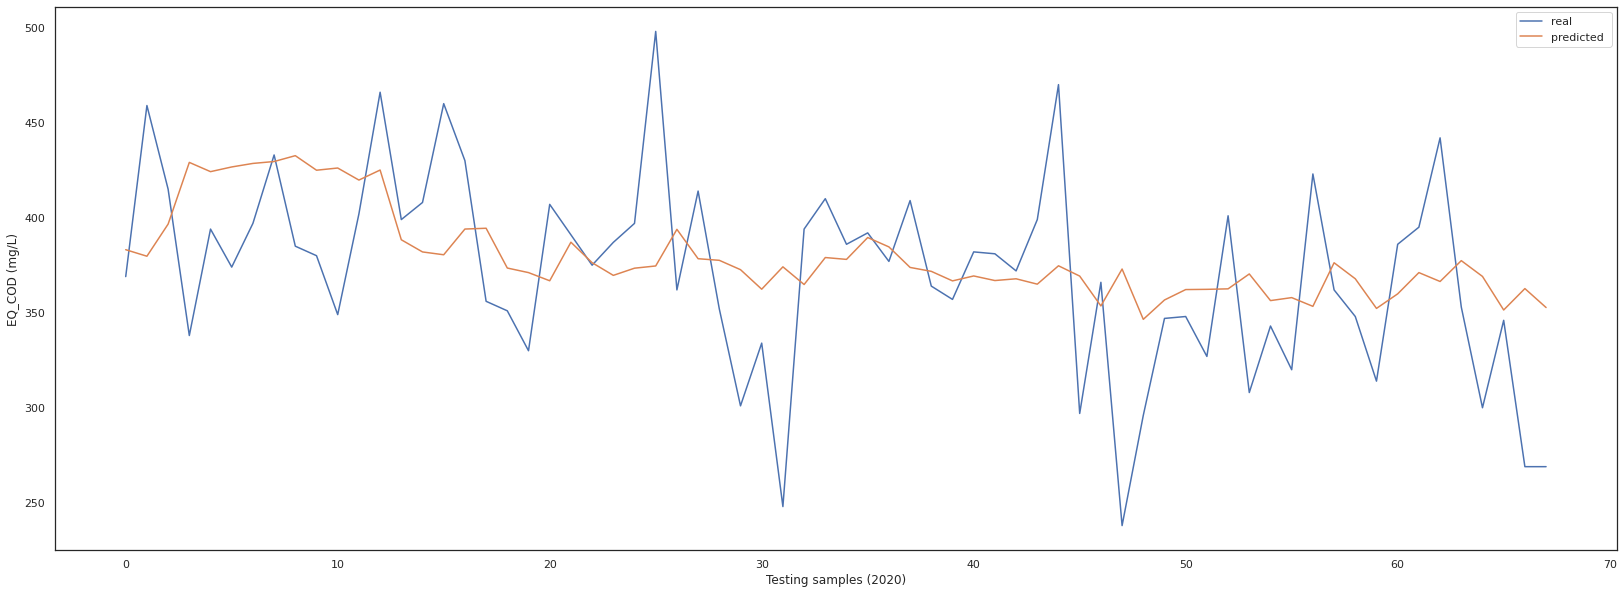

(68,)

In [90]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  11.471277317968406


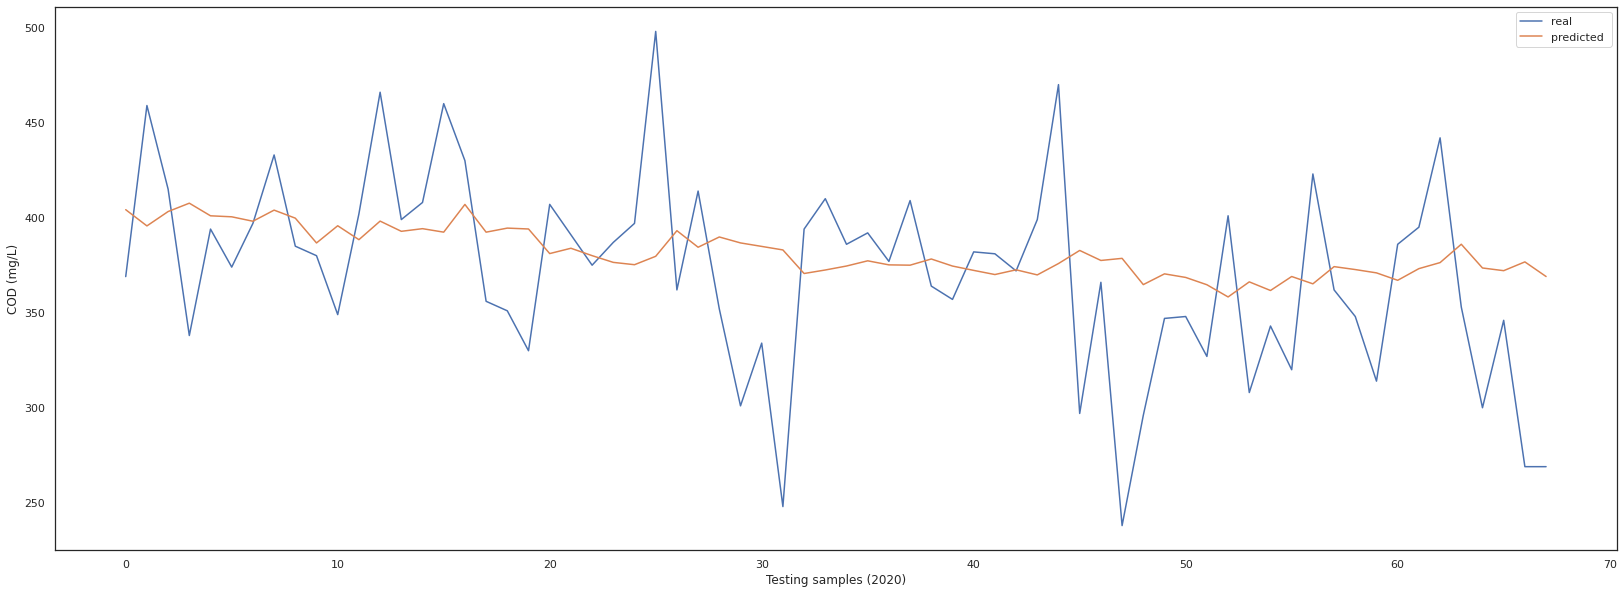

In [91]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[15.06015   13.85649   14.820531  15.179743  13.672251  13.54502
 13.404341  14.080172  12.814098  11.7287855 12.206727  11.711913
 12.538068  13.631211  13.421528  13.226834  15.115295  13.027275
 14.836242  14.062573  11.705479  12.067863  11.91812   11.340882
 11.348538  11.556497  13.22694   12.303215  13.127077  12.735044
 12.438486  11.899815  11.342451  11.341629  11.389793  11.377516
 11.356861  11.341319  11.364972  11.343563  11.339631  11.341357
 11.341077  11.343596  11.374465  12.046194  11.500878  11.793723
 11.417372  11.576659  11.500969  11.704112  12.006475  11.503425
 12.091618  11.637933  11.845934  11.341093  11.35483   11.564809
 11.696105  11.340627  11.339658  12.46525   11.353252  11.383375
 11.339567  11.4155245], shape=(68,), dtype=float32)
MAPEsci:  3936.528239530676
MAPE:  12.24154134739533
R2:  -0.012491934179702957
RMSE:  51.691285402959124


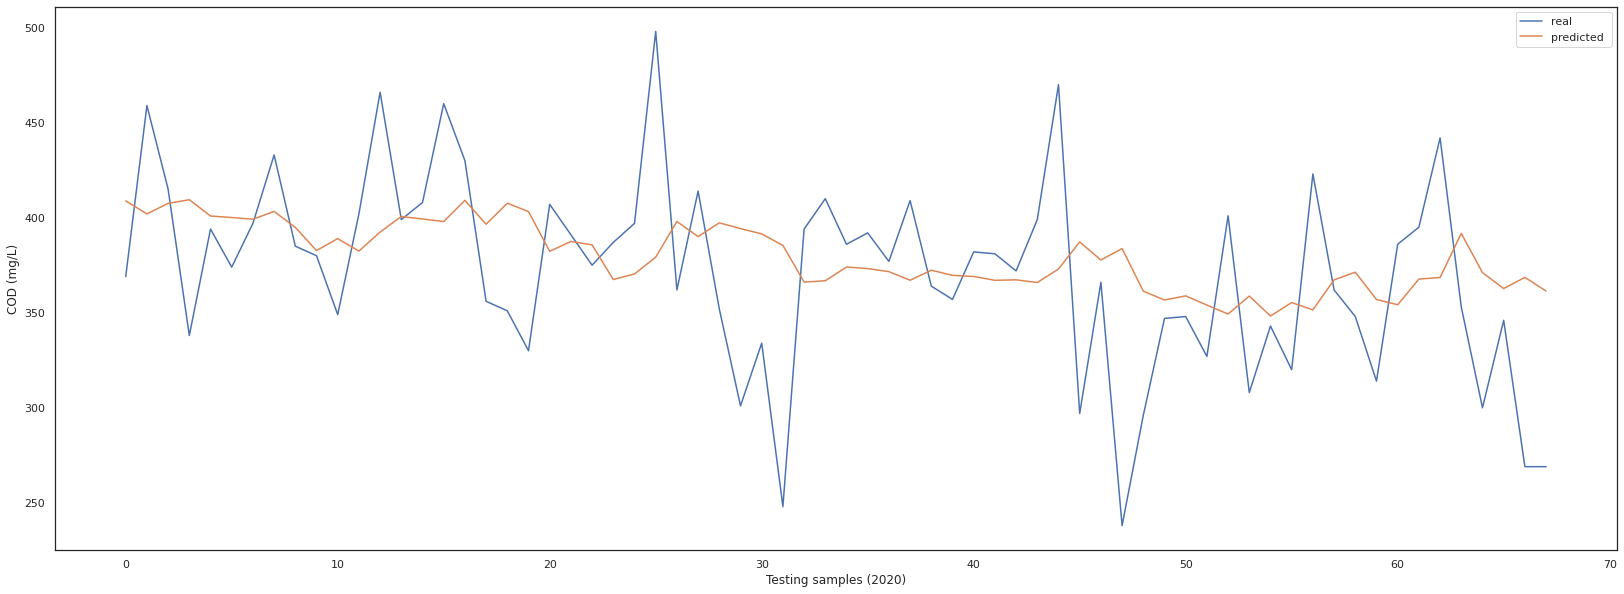

In [92]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[11.731322  12.405526  11.614835  12.501271  11.638095  12.056921
 11.650482  11.971664  11.6673565 11.4067335 11.355742  11.339891
 11.442928  11.533558  12.155676  12.003485  11.453403  12.220815
 12.188654  12.320399  11.737076  12.476518  11.499423  11.986056
 11.5536995 11.867947  11.419481  11.948354  11.815133  12.276995
 11.846924  12.087909  11.727456  11.714893  11.450044  11.740201
 11.782294  11.806566  11.854191  11.463705  11.358277  11.358064
 11.443358  11.355957  11.5599985 11.340982  11.420784  11.4466
 11.920013  11.341124  11.364909  11.34141   11.562601  11.399942
 11.438055  11.44366   11.339497  11.785906  11.354936  11.601866
 11.341287  11.483071  11.751885  11.558514  11.362054  11.360377
 11.789763  11.418861 ], shape=(68,), dtype=float32)
MAPE:  11.67584386046971
R2:  0.017733879170018674
RMSE:  50.91387222909811


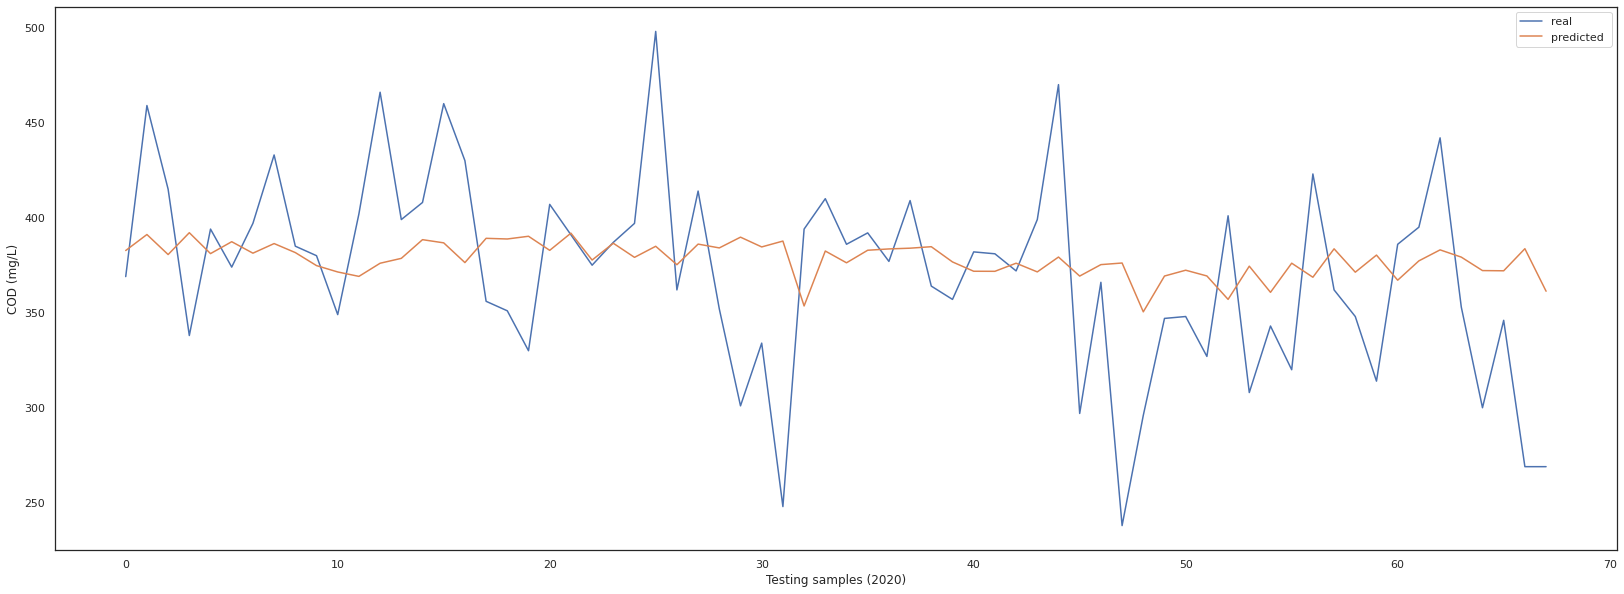

In [93]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

3/3 [==============================] - 0s 3ms/step - loss: 1.1238 - accuracy: 0.2647
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(13.486607076554998, shape=(), dtype=float64)
MAPEsci:  4630.488215089868
MAPE:  13.486607076554998
R2:  -0.3002611109905535
RMSE:  58.57830926658036


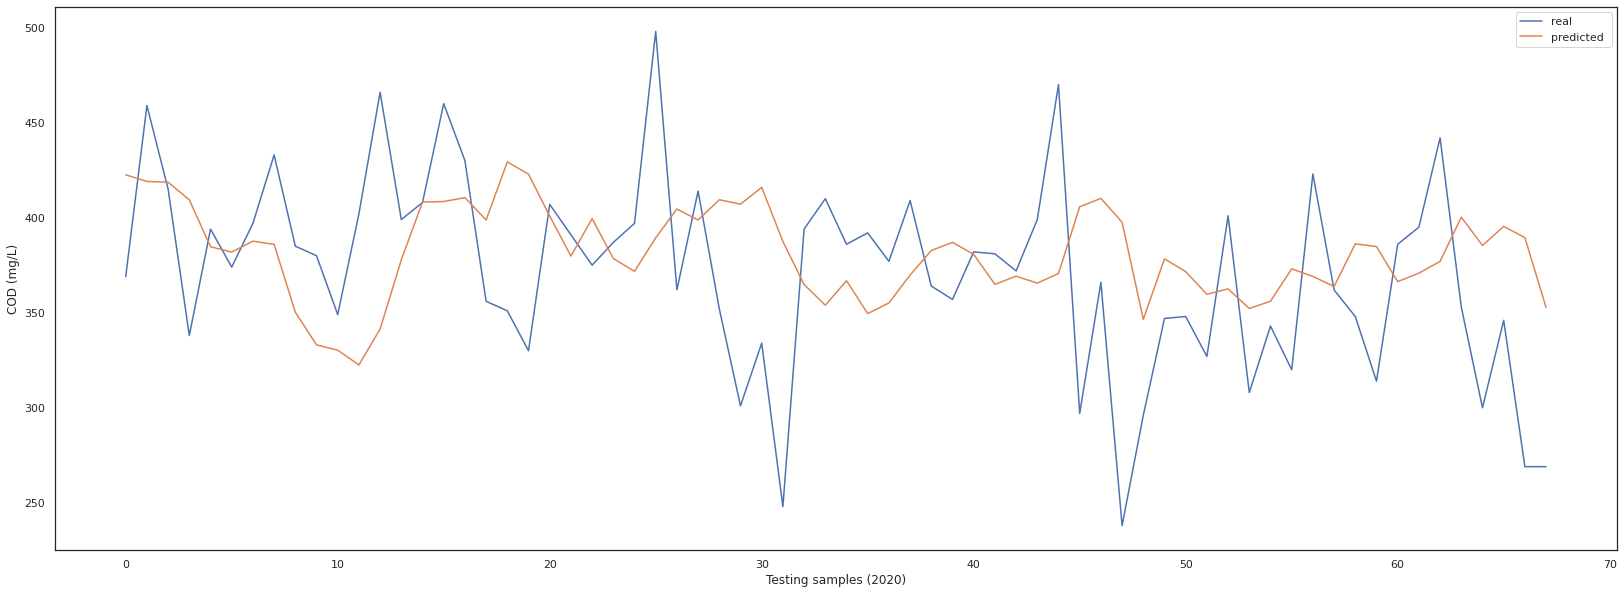

In [94]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [95]:
ensemble_model3.selection.to_list().count(3)

0

# D_COD_ON

In [35]:
active_target = "D_COD_ON"
dataset = dataset2.copy()
dataset.shape
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

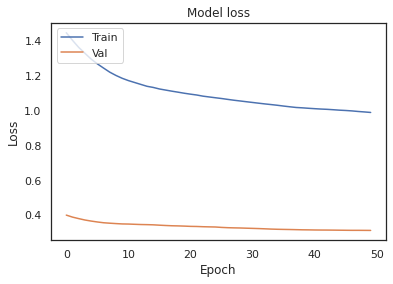

*** ANN estimation ***
MAPE:  15.611200472291644
R2:  0.47176520987340165
RMSE:  22.757499342755256


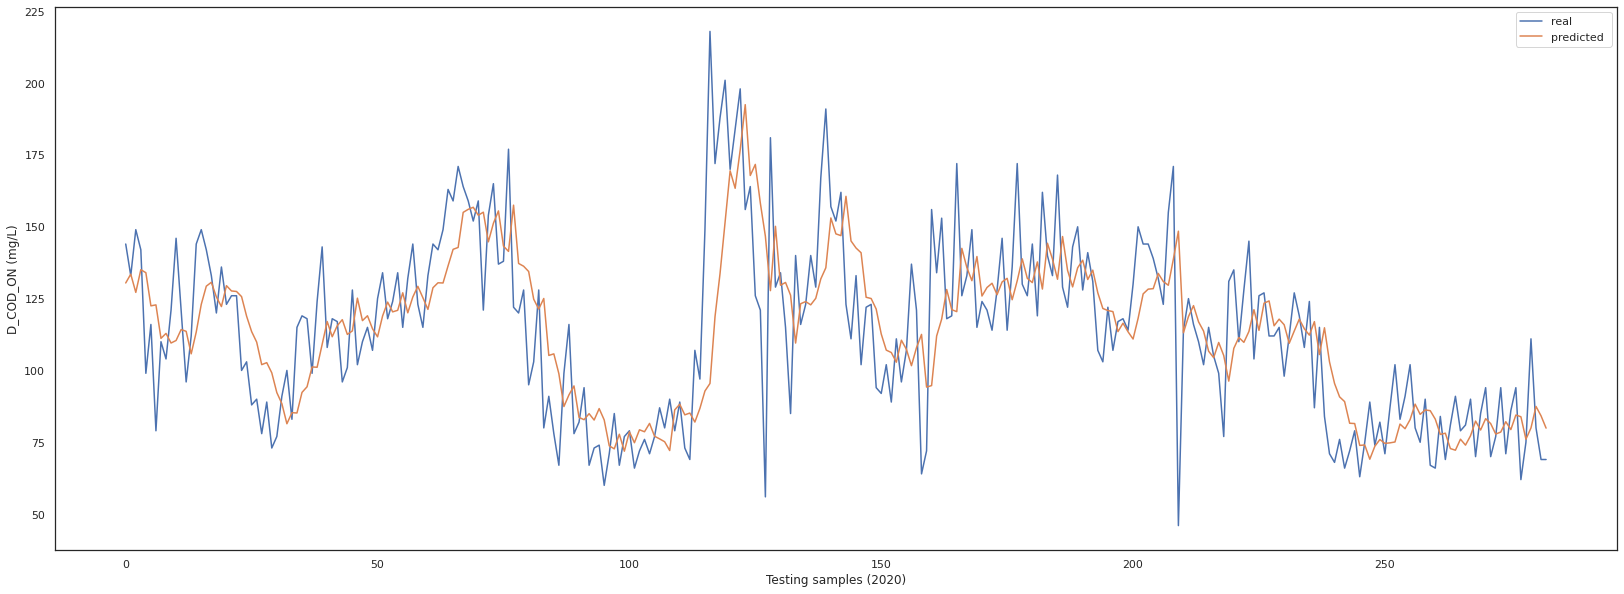

(283,)

In [8]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

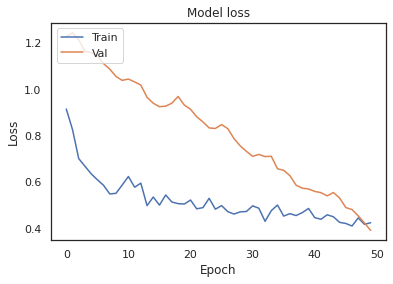

*** LSTM estimation ***
MAPE:  27.710517258059248
R2:  0.5650957573509248
RMSE:  20.64942013650829


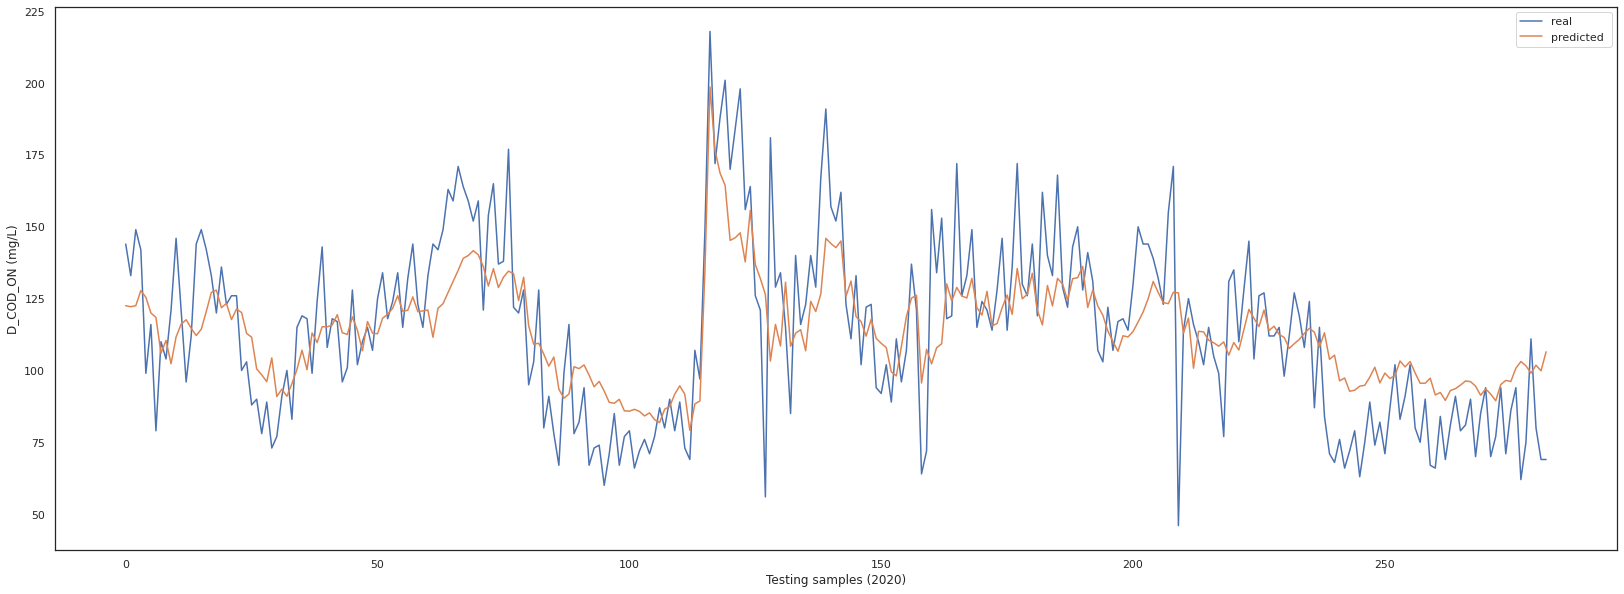

(283, 1)

In [9]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  15.677703541659154
R2:  0.5019827302172664
RMSE:  22.096996146213552


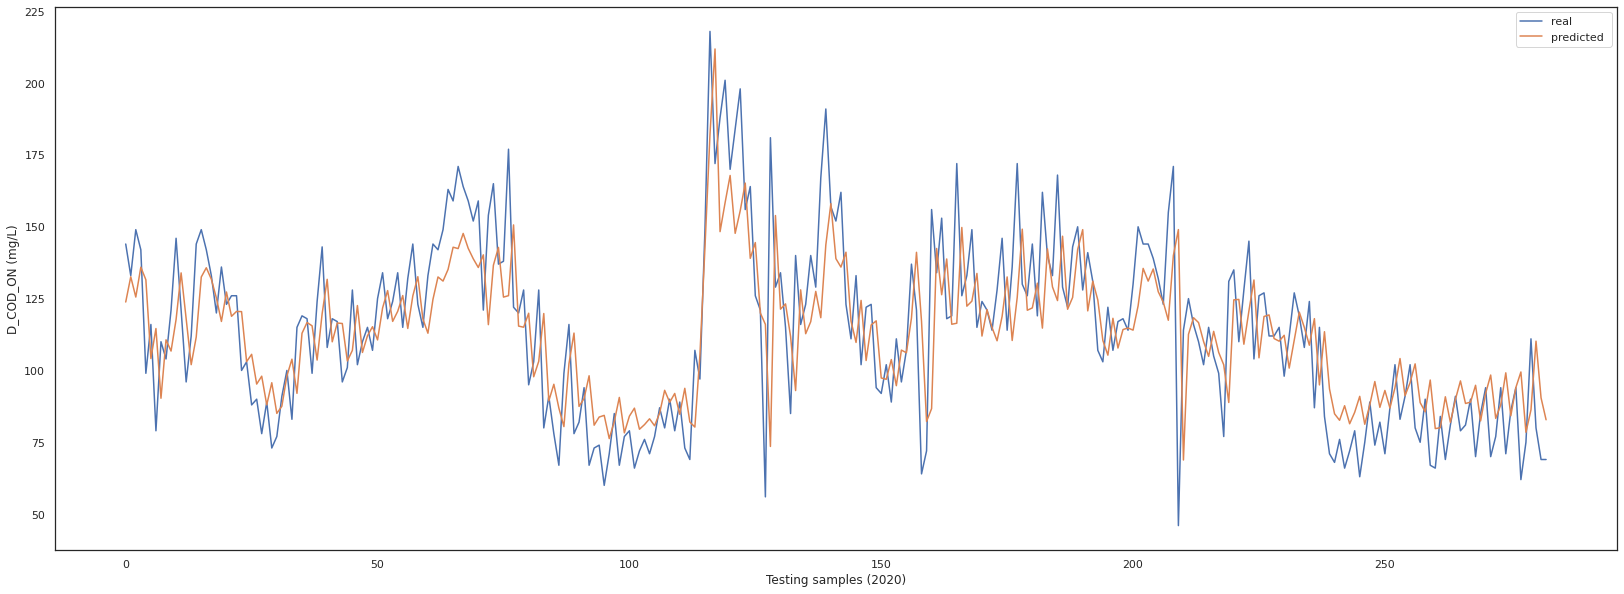

(283,)

In [10]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

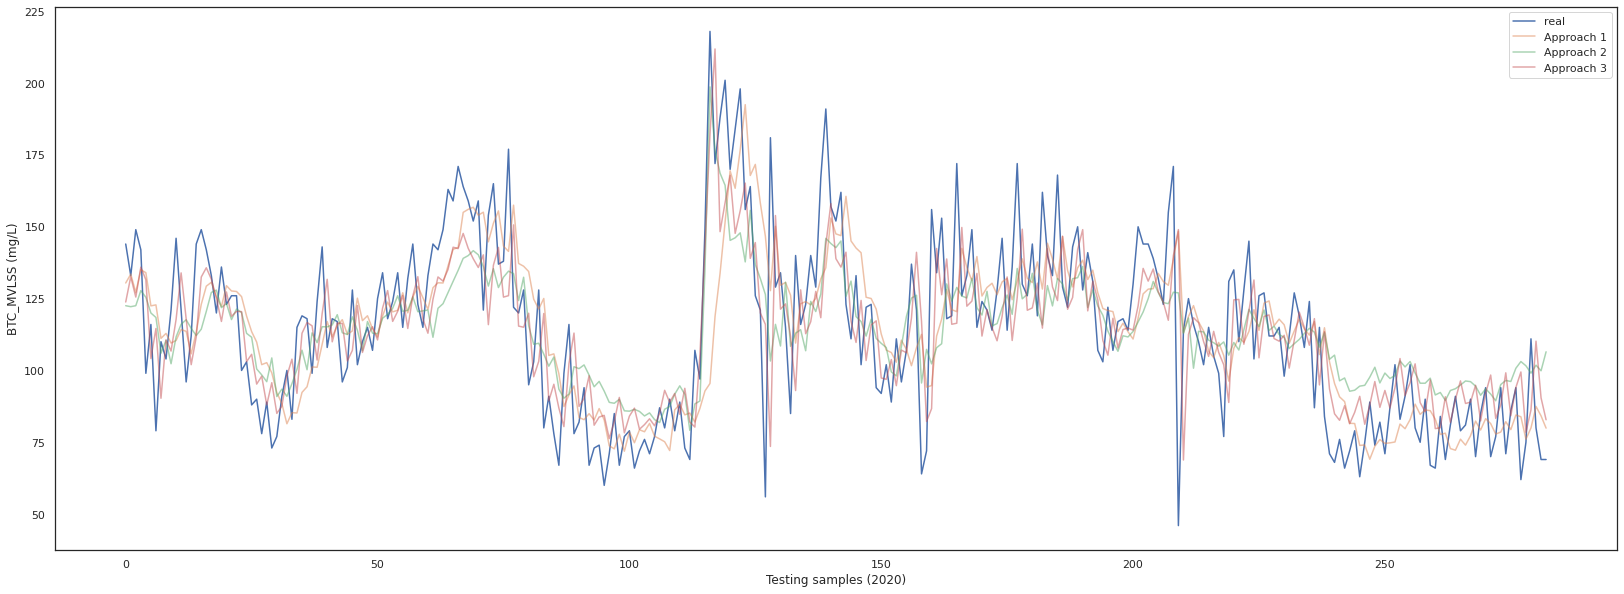

In [11]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [12]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      376.789359
1      388.292093
2      375.245807
3      398.782993
4      391.049075
          ...    
278    256.166915
279    265.324078
280    299.487141
281    274.547071
282    269.248861
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  15.04992465819498
R2:  0.5424482430272409
RMSE:  21.18025341876615


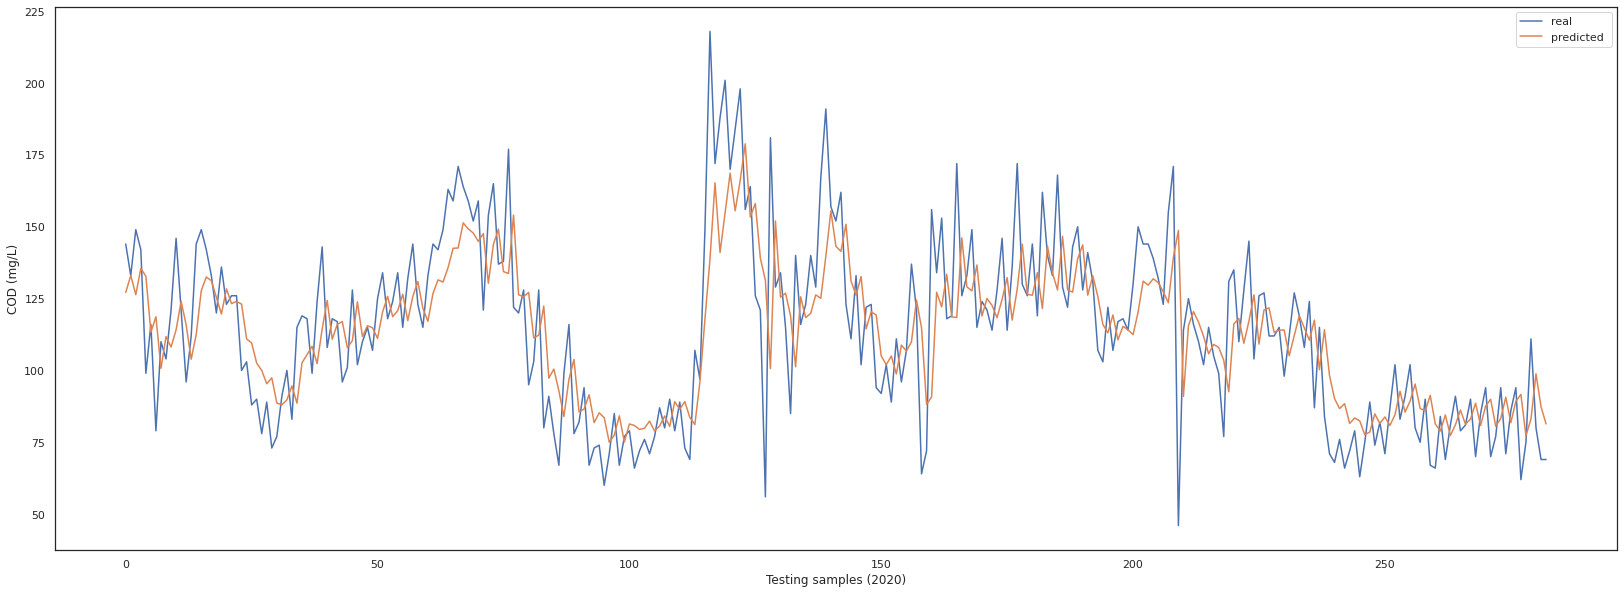

In [13]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  14.906628068451965
R2:  0.5753547366491734
RMSE:  20.40441652842001


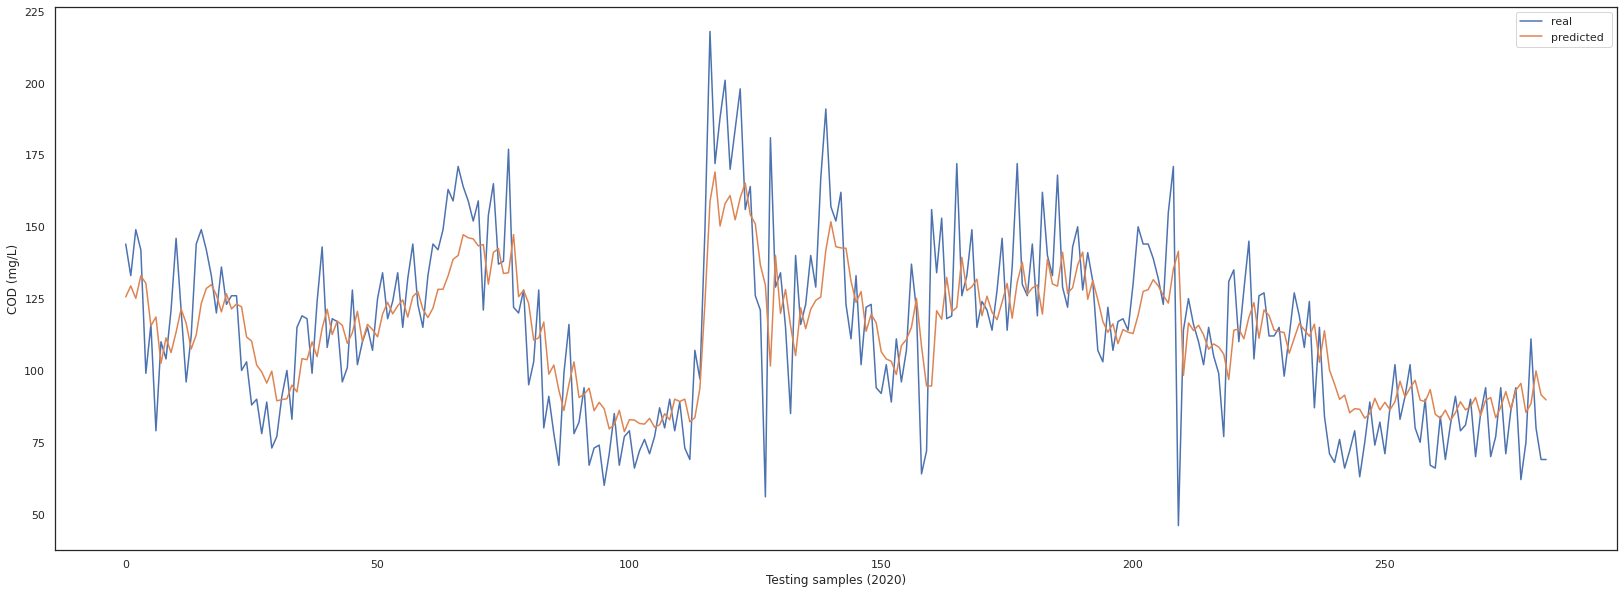

In [14]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [15]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 41ms/step - loss: 0.8053 - MAPE: 125.7036 - val_loss: 0.5194 - val_MAPE: 65.0119
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7435 - MAPE: 123.1775 - val_loss: 0.4277 - val_MAPE: 59.9151
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6922 - MAPE: 119.7443 - val_loss: 0.3534 - val_MAPE: 56.1294
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6436 - MAPE: 122.0557 - val_loss: 0.3102 - val_MAPE: 55.0905
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6063 - MAPE: 127.9959 - val_loss: 0.2799 - val_MAPE: 55.4843
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5721 - MAPE: 140.6537 - val_loss: 0.2564 - val_MAPE: 56.2709
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5421 - MAPE: 145.4856 - val_loss: 0.2424 - val_MAPE: 56.9486
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss

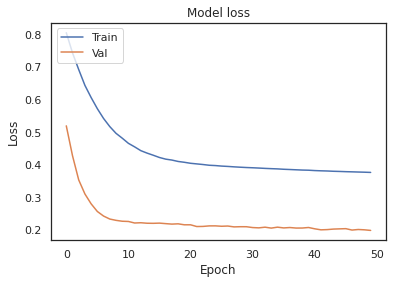

In [16]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 31.777298  30.647198  30.930943  33.934982  33.11096   29.655869
  29.068705  24.095863  24.393223  24.166029  25.758404  28.295677
  28.147358  24.953045  24.727076  26.79116   28.341251  33.43809
  33.5566    30.33427   31.625458  29.284624  30.851482  29.916351
  25.868803  24.613522  24.5245    25.017149  26.249868  24.454744
  28.681126  27.50147   27.16385   25.430614  25.298706  24.239496
  24.276321  25.947624  24.141827  27.176237  27.422815  26.29926
  28.984972  26.140451  24.768726  28.182135  26.789661  24.264694
  28.02265   25.611845  24.805275  28.039043  28.24504   29.940615
  32.657284  29.715992  29.686192  32.157433  28.825356  30.32454
  30.08383   26.475964  29.721922  30.963451  34.00695   36.345394
  39.62808   45.262745  47.78969   49.557377  47.955765  44.951912
  39.548923  43.76793   38.241787  40.511806  41.27893   40.516834
  34.947006  39.20217   29.482597  25.678263  25.16629   25.045815
  25.057343  

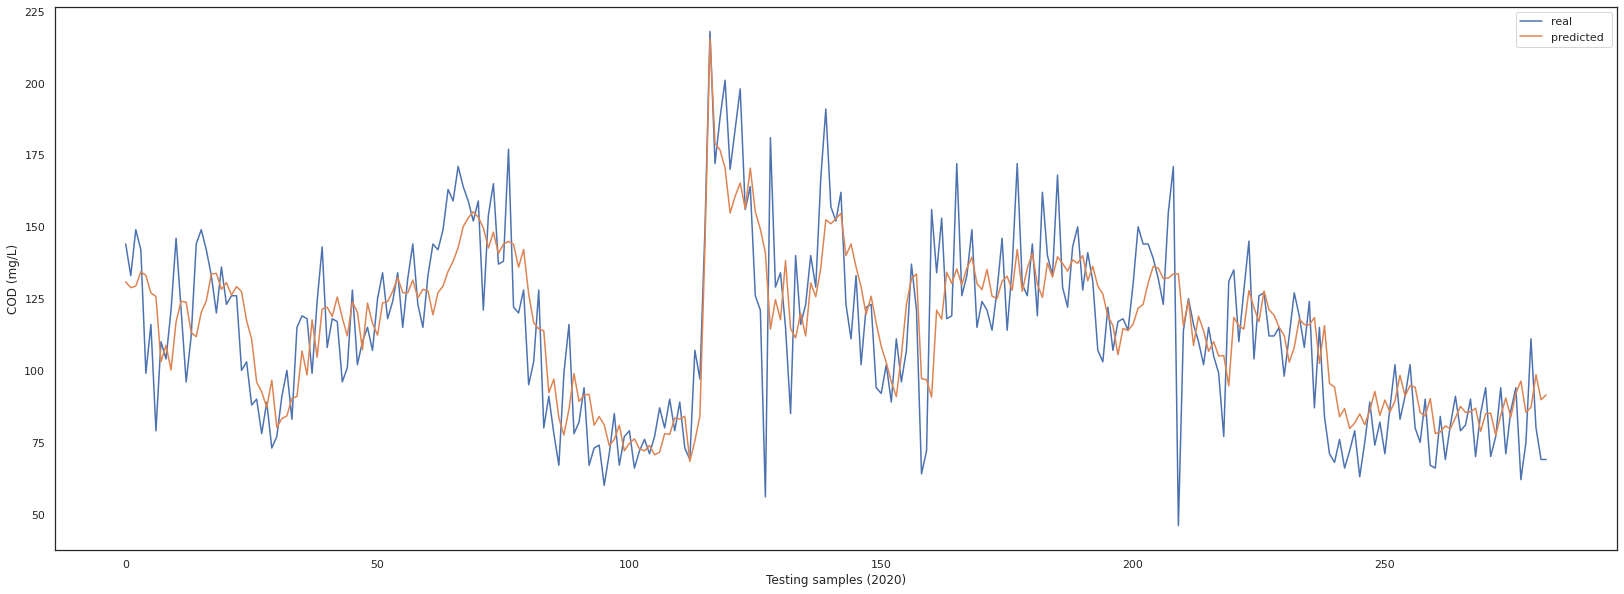

In [17]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [18]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 21ms/step - loss: 1.8098 - MAPE: 296.8070 - val_loss: 0.9408 - val_MAPE: 84.2552
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.6477 - MAPE: 278.7628 - val_loss: 0.8226 - val_MAPE: 80.0093
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5072 - MAPE: 274.1025 - val_loss: 0.7110 - val_MAPE: 75.5955
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.3727 - MAPE: 263.2322 - val_loss: 0.6267 - val_MAPE: 71.9145
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2642 - MAPE: 254.8418 - val_loss: 0.5514 - val_MAPE: 68.2955
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1676 - MAPE: 266.4803 - val_loss: 0.4826 - val_MAPE: 64.6970
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0786 - MAPE: 274.4417 - val_loss: 0.4288 - val_MAPE: 61.6342
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss

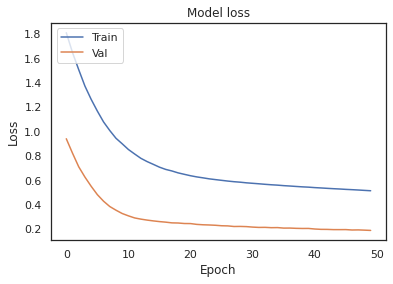

In [19]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[31.420717 38.054455 33.75158  40.72823  36.862064 24.811405 26.89425
 24.206608 24.403732 24.126455 26.676804 38.65609  28.131899 24.248903
 24.769676 37.45666  41.758995 38.167416 34.026825 28.569752 34.565468
 28.306082 29.80602  30.173752 24.524841 24.412237 24.373337 24.71774
 25.266293 24.28098  27.161917 26.569933 27.16148  25.633362 25.179604
 24.39436  24.229681 26.049133 24.123564 28.63831  36.992855 24.915886
 27.519093 26.071781 24.298386 24.726421 30.15211  24.19243  25.346962
 25.506834 24.477083 29.711966 33.884655 27.930897 30.417788 33.900703
 26.970741 34.048107 38.8184   28.671202 26.751114 30.852684 38.794483
 37.73726  39.59379  45.688286 44.52135  45.794403 40.01769  36.375923
 34.34268  38.041374 24.643349 36.065754 40.607323 29.450792 30.284256
 48.2353   25.371944 24.876434 27.841415 24.12033  24.240791 26.716583
 24.503305 24.15205  25.892656 27.977455 25.90369  24.13446  25.331852
 25.06617  25.235378 27.210

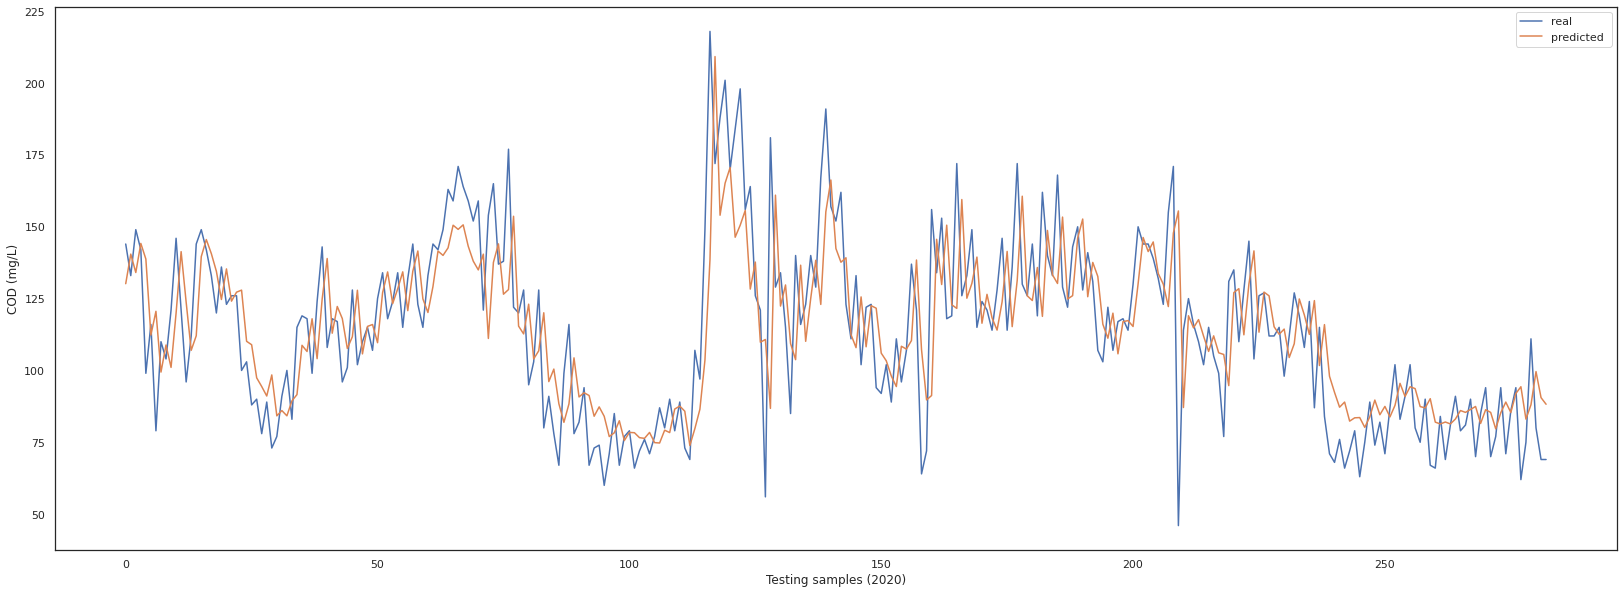

In [20]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [21]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    0  0  1
2    1  0  0
3    0  0  1
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  1  0
280  1  0  0
281  1  0  0
282  1  0  0

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 0s 24ms/step - loss: 1.1791 - accuracy: 0.3031 - val_loss: 1.0171 - val_accuracy: 0.5517
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1590 - accuracy: 0.3031 - val_loss: 1.0168 - val_accuracy: 0.5517
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1443 - accuracy: 0.2795 - val_loss: 1.0155 - val_accuracy: 0.5517
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1298 - accuracy: 0.2835 - val_loss: 1.0153 - val_accuracy: 0.5517
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1187 - accuracy: 0.3150 - val_loss: 1.0145 - val_accuracy: 0.5517
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1097 - accuracy: 0.3307 - val_loss: 1.0

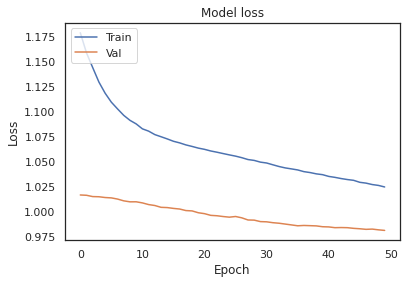

In [22]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

9/9 [==============================] - 0s 1ms/step - loss: 1.0197 - accuracy: 0.4876
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(13.934000133983366, shape=(), dtype=float64)
MAPEsci:  1489.423124866106
MAPE:  13.934000133983371
R2:  0.6033462228423123
RMSE:  19.72045066530102


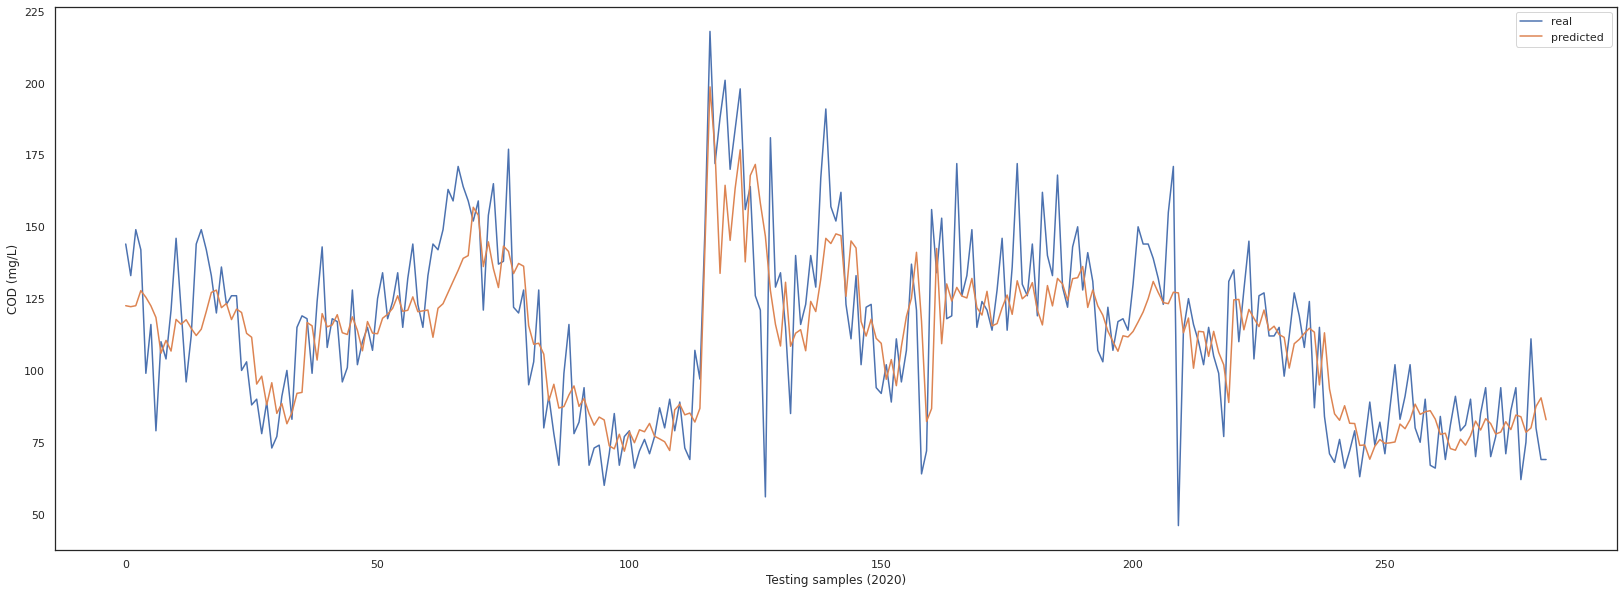

In [23]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [24]:
ensemble_model3.selection.to_list().count(1)

150

### Ensemble 4

In [25]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [26]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  16.67020196287093
R2:  0.21820837363491752
RMSE:  17.11595612864512


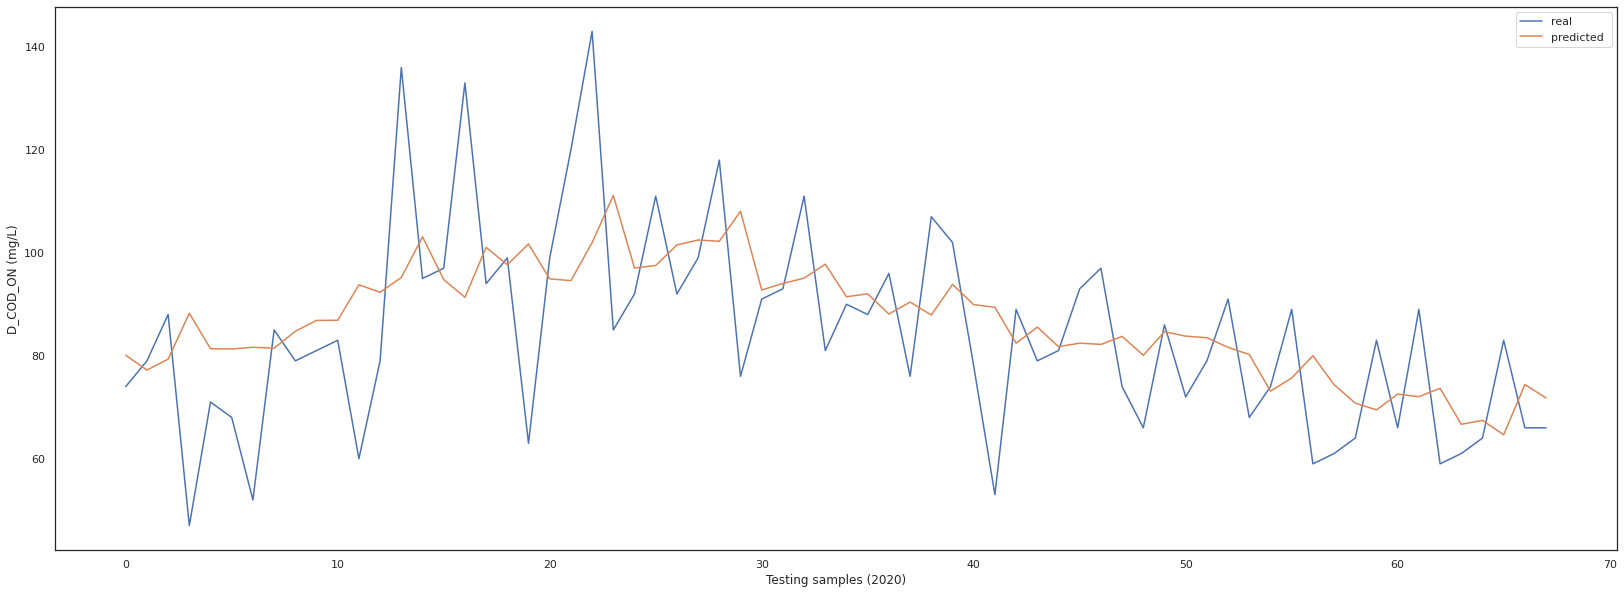

(68,)

In [27]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  26.114873208353888
R2:  -0.18566117660716563
RMSE:  21.078318238540827


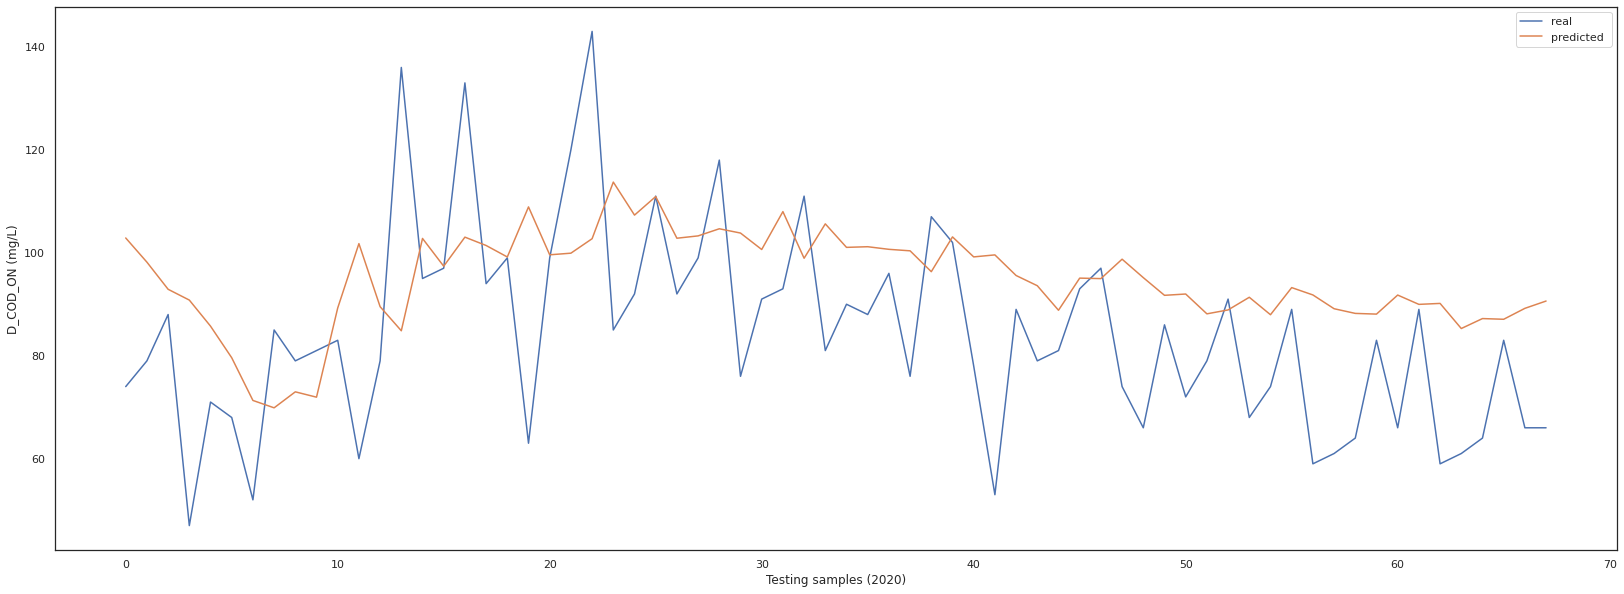

(68, 1)

In [28]:
app2.testing(dataset.iloc[-(cut_off + 2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  21.067376552813588
R2:  -0.13242930233339023
RMSE:  20.599714751501136


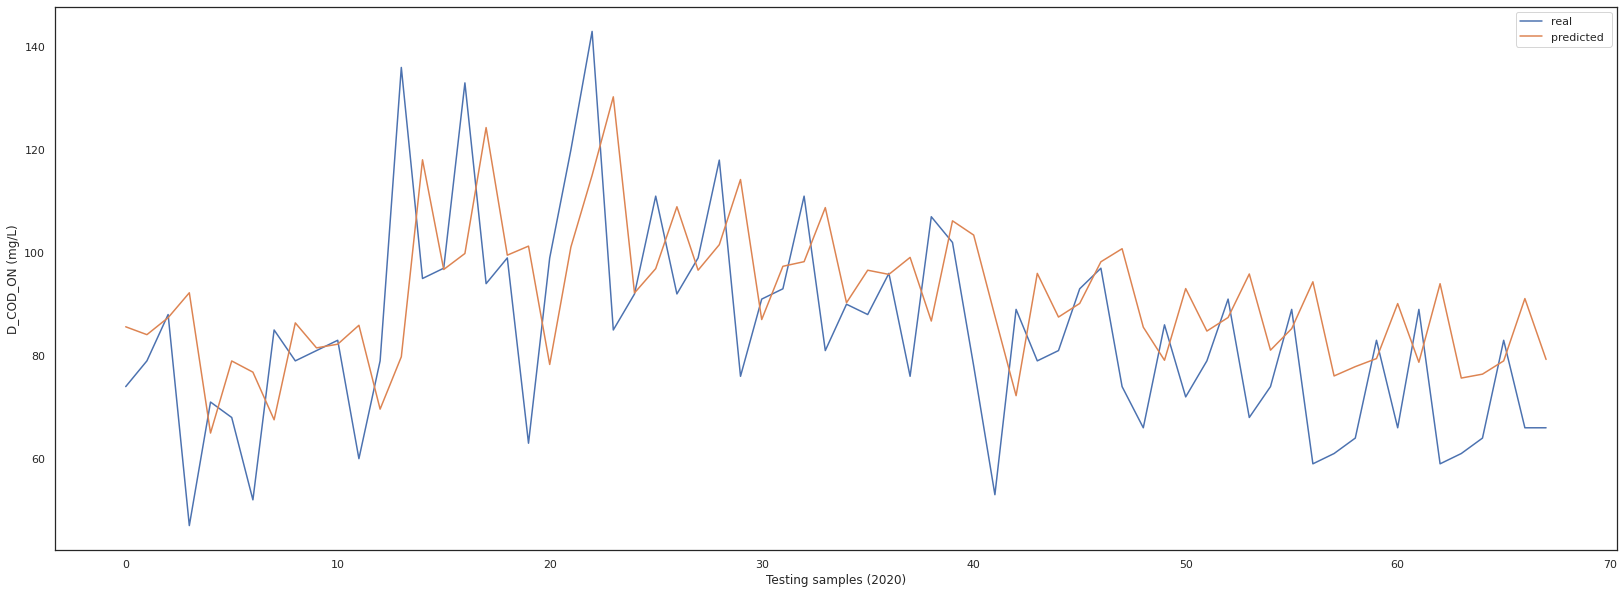

(68,)

In [29]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  19.198710508883092


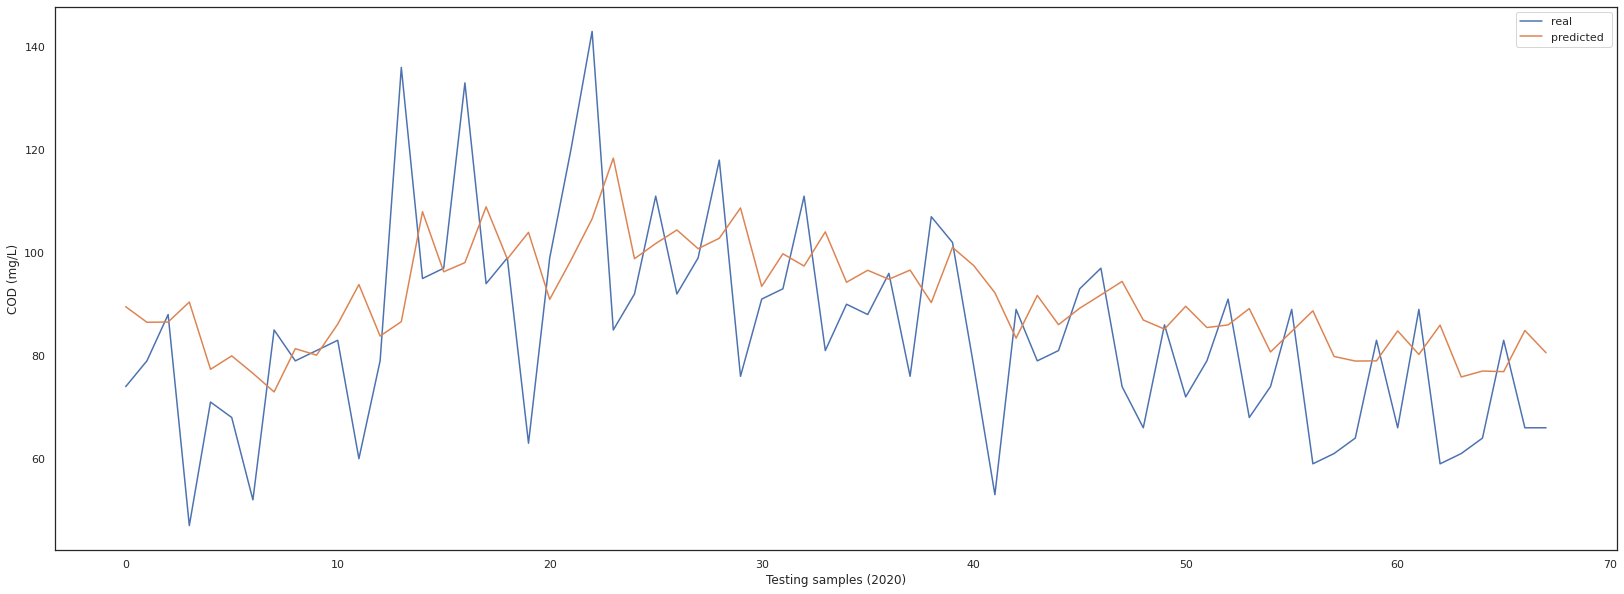

In [30]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[21.077797 18.957026 18.107897 18.218891 21.682178 21.32217  27.71333
 32.983852 24.309336 25.899467 17.946102 20.93889  19.21601  18.754595
 31.825443 21.437696 26.095104 35.4193   23.43524  32.28645  18.72791
 24.35617  30.578842 54.207283 27.434557 33.686344 29.467443 25.579828
 28.604322 32.04819  20.69424  29.39567  22.772133 32.30722  21.658005
 23.631916 22.883238 23.83543  18.957087 28.72226  24.232687 20.28435
 17.86819  19.460054 17.748789 18.97736  20.245235 23.015804 18.388021
 17.836723 18.533455 17.960777 17.747171 18.57008  18.361208 17.965633
 18.592672 18.585033 18.6571   18.529852 18.075071 18.196724 18.074993
 20.036314 19.22268  18.94365  17.828846 18.061089], shape=(68,), dtype=float32)
MAPEsci:  1456.905112547033
MAPE:  22.899624007974886
R2:  0.05789932972782774
RMSE:  18.789028007421507


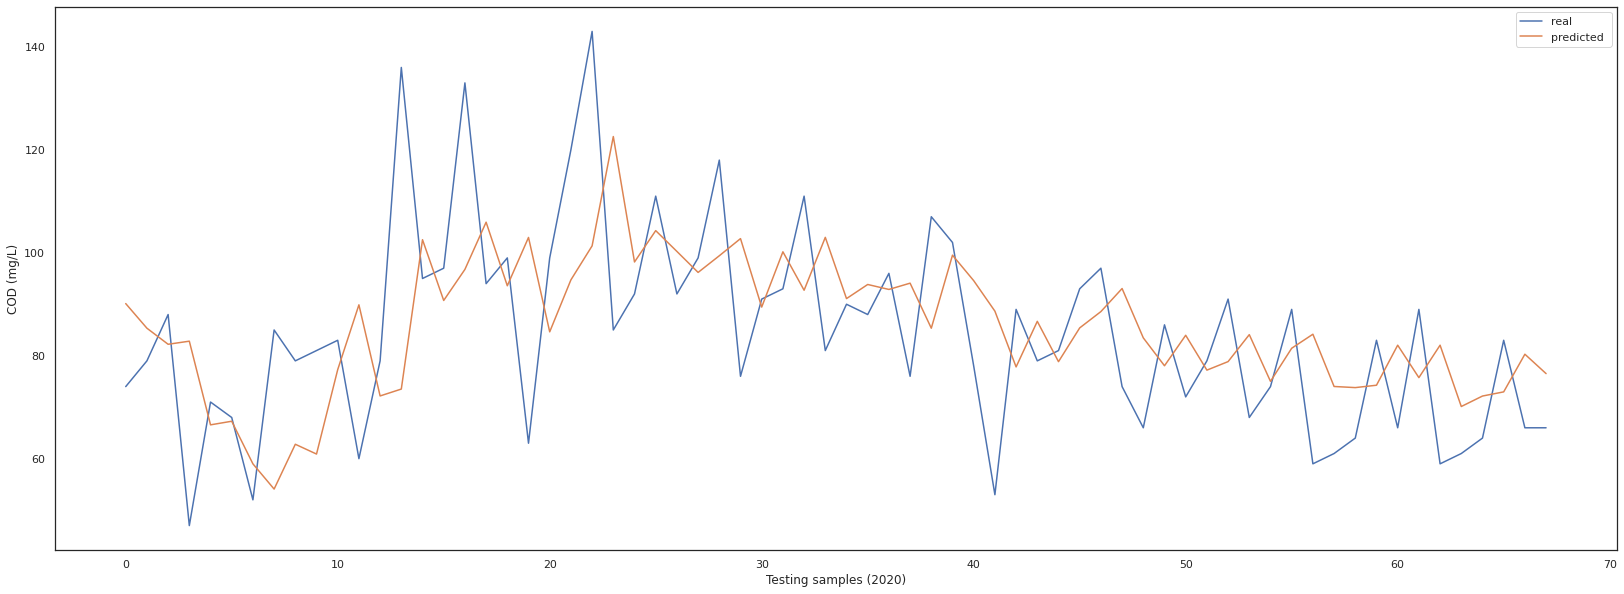

In [31]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[20.721891 19.60725  18.600039 19.119184 18.502642 18.82041  21.718962
 24.274422 19.622099 20.126583 18.484222 24.594082 18.039665 18.035658
 56.921875 23.20168  26.11202  52.66147  24.405432 33.819237 19.884026
 24.988708 39.834118 72.869835 28.065937 32.55574  30.55224  27.99615
 30.070799 39.329025 22.38522  29.303356 23.74403  33.037968 23.077595
 24.283014 22.948786 24.138523 19.988167 28.148338 23.73131  21.720446
 17.770958 19.651615 17.973604 19.458052 19.896393 21.878956 18.917194
 18.139448 18.94777  17.812847 17.979837 18.696312 17.935486 18.22637
 18.73153  17.974913 18.155258 18.132612 18.097492 17.78388  18.036234
 19.073439 18.452585 18.515762 17.847374 17.739384], shape=(68,), dtype=float32)
MAPE:  23.85099224326162
R2:  0.0002294877324946487
RMSE:  19.355563480750753


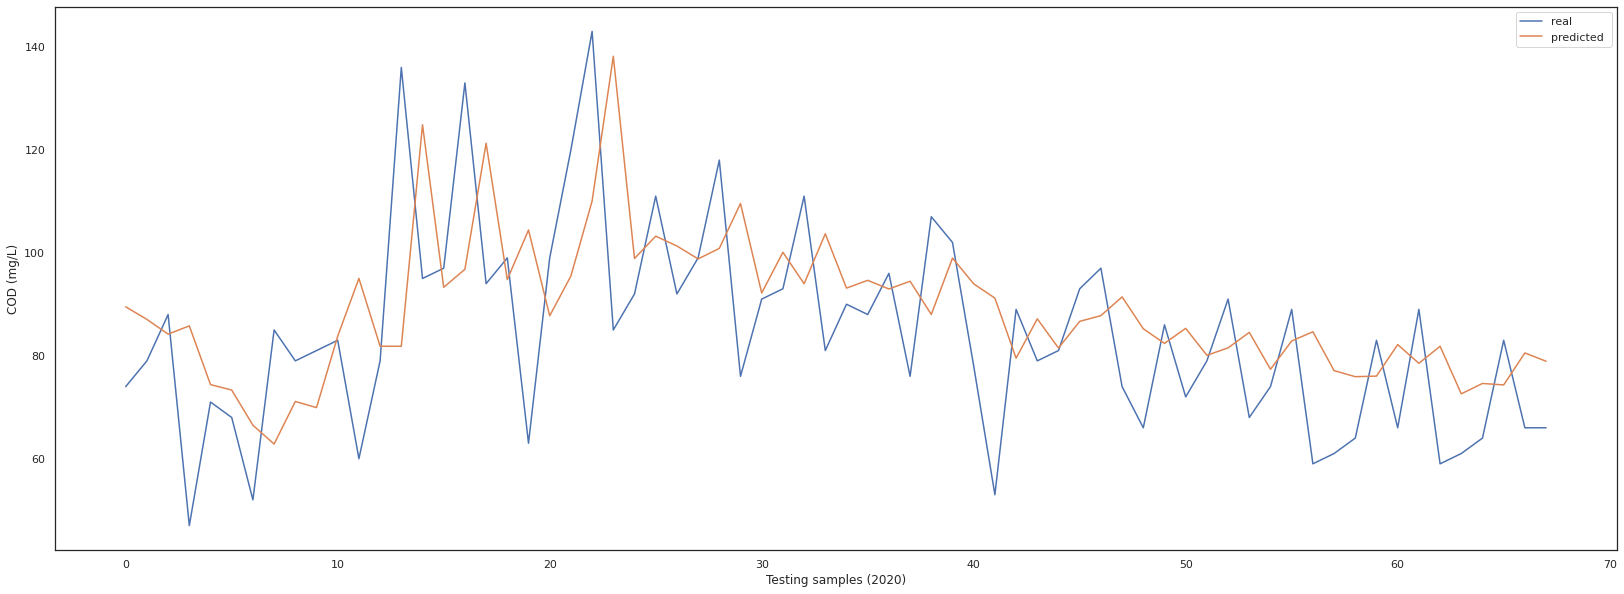

In [32]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

3/3 [==============================] - 0s 2ms/step - loss: 1.0240 - accuracy: 0.5147
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(17.676749805932847, shape=(), dtype=float64)
MAPEsci:  1383.9435934271664
MAPE:  17.67674980593284
R2:  0.1511796610230869
RMSE:  17.83460709557956


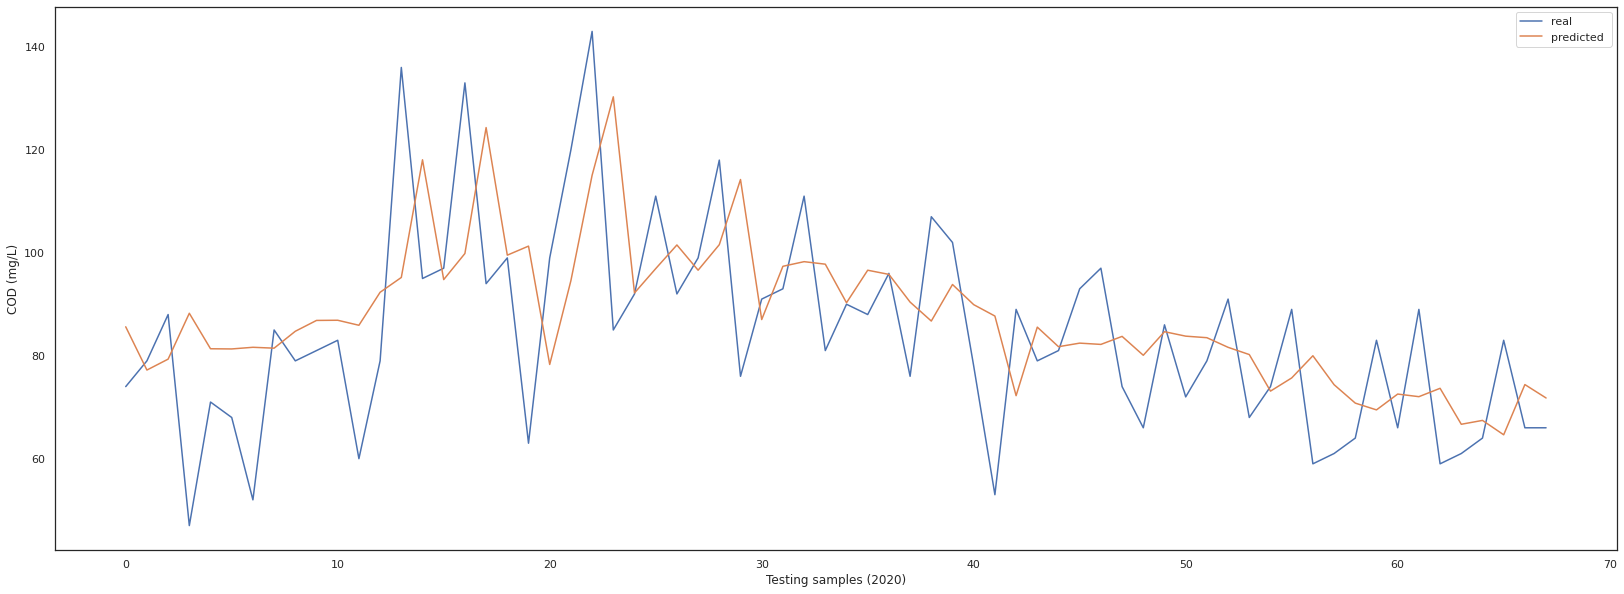

In [33]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [34]:
ensemble_model3.selection.to_list().count(3)

0